Process 5 way breakdown

In [97]:
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import torch
from scipy import stats
import sklearn
from sklearn import inspection

sys.path.insert(0, 'src')
from utils.utils import read_lists, load_image, ensure_dir, write_lists, informal_log, read_json
from utils.visualizations import plot, show_image_rows, make_grid, bar_graph
from utils.df_utils import convert_string_columns, string_to_numpy, string_to_list, save_csv
from explainer_generate_csv import generate_csv
# from utils.attribute_utils import hyperparam_search
# from utils.metric_utils import sort_and_bin_df, calculate_bin_agreement, plot_alignment, run_feature_importance_trial, correlated_variables, print_summary, filter_df, string_to_list, plot_metric_v_inputs, get_coefficient_significance
# import model.metric as module_metric


# Setup
* Assumes that CSV exists with all the human, model, explainer uncertainties (entropy, t2c, top_confidence) and alignment (h-e, h-m, m-e)

## Generate CSV with uncertainties, alignment, and 5 way break down encoded one-hot, calculate n_params


In [49]:
dataset_name = 'cifar'
if dataset_name == 'cifar':
    explainer_dirs = [
        # pixel-RGB
        # 'saved_explainers/cifar/pixel/RGB/hidden_NA',
        # 'saved_explainers/cifar/pixel/RGB/hidden_128',
        # 'saved_explainers/cifar/pixel/RGB/hidden_128_128',
        # 'saved_explainers/cifar/pixel/RGB/hidden_256',
        # 'saved_explainers/cifar/pixel/RGB/hidden_256_256',
        # 'saved_explainers/cifar/pixel/RGB/hidden_1024',
        # pixel-intensity
        # 'saved_explainers/cifar/pixel/intensity/hidden_NA',
        # 'saved_explainers/cifar/pixel/intensity/hidden_128',
        # 'saved_explainers/cifar/pixel/intensity/hidden_128_128',
        # 'saved_explainers/cifar/pixel/intensity/hidden_256',
        # 'saved_explainers/cifar/pixel/intensity/hidden_256_256',
        # 'saved_explainers/cifar/pixel/intensity/hidden_1024',
        # SIFT (K=500) based
        # 'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_NA',
        # 'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128',
        # 'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128_128',
        # 'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256',
        # 'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256_256',
        # 'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_1024',
        # SIFT (K=500) based
        'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA',
        'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128',
        'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128_128',
        'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256',
        'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256_256',
        'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_1024',
    ]

    human_outputs_path = 'data/cifar10-soft-labels/cifar10h-probs.npy'
    model_outputs_path = 'saved/cifar10/resnet18/outputs_predictions.pth'
else:
    raise ValueError("Unsupported dataset {}".format(dataset_name))

In [50]:
for idx, e_dir in enumerate(explainer_dirs):
    explainer_outputs_path = os.path.join(e_dir, 'outputs_predictions.pth')
    
    print("{}/{} Processing explainer {}".format(idx+1, len(explainer_dirs), e_dir))
    generate_csv(
        dataset_name=dataset_name,
        human_output_path=human_outputs_path,
        model_output_path=model_outputs_path,
        explainer_output_path=explainer_outputs_path,
        csv_save_dir=e_dir)

1/7 Processing explainer saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_1024
Adding outputs to dataframe...
Adding uncertainty to dataframe...
Adding alignment to dataframe...
Adding 5 way breakdown to dataframe...
35.440% samples in case1
1.670% samples in case2
57.470% samples in case3
1.320% samples in case4
4.100% samples in case5
Saved dataframe to saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_1024/uncertainties_alignment.csv
2/7 Processing explainer saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA
Adding outputs to dataframe...
Adding uncertainty to dataframe...
Adding alignment to dataframe...
Adding 5 way breakdown to dataframe...
32.210% samples in case1
1.560% samples in case2
60.700% samples in case3
1.390% samples in case4
4.140% samples in case5
Saved dataframe to saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA/uncertainties_alignment.csv
3/7 Processing explainer saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000

In [ ]:
# Calculate n_params
def calculate_n_params(dims,
                       bias=True):
    inputs = dims[:-1]
    outputs = dims[1:]
    n_layers = len(outputs)
    n_params = 0
    for idx, (input, output) in enumerate(zip(inputs, outputs)):
        n_params += input * output
        if bias:
            n_params += output
    return n_params



for explainer_dir in explainer_dirs:
    if 'RGB' in explainer_dir:
        in_channels = 3072
    elif 'intensity' in explainer_dir:
        in_channels = 1024
    elif 'K_500' in explainer_dir:
        in_channels = 500
    elif 'K_2000' in explainer_dir:
        in_channels = 2000
    else:
        raise ValueError("Unrecognized directory {}".format(explainer_dir))
    
    hidden_str = os.path.basename(explainer_dir)
    hidden_str = hidden_str.split('_')[1:]
    try:
        hidden_channels = []
        for h in hidden_str:
            h = int(h)
            hidden_channels.append(h)
    except:
        hidden_channels = []
    layers = [in_channels] + hidden_channels + [10]
    n_params = calculate_n_params(
        dims=layers,
        bias=True)
    hparam_json_path = os.path.join(explainer_dir, 'hparams.json')
    hparam_json = read_json(hparam_json_path)
    hparam_json['n_params'] = n_params
    print(explainer_dir, n_params)
    write_json(hparam_json, hparam_json_path)

## Compare CSVs of various explainers

In [51]:
explainer_dirs = [
    # SIFT based (K=500)
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_NA',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128_128',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256_256',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_1024',
    # SIFT based (K=2000)
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128_128',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256_256',
    'saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_1024',
    # pixel-intensity
    'saved_explainers/cifar/pixel/intensity/hidden_NA',
    'saved_explainers/cifar/pixel/intensity/hidden_128',
    'saved_explainers/cifar/pixel/intensity/hidden_128_128',
    'saved_explainers/cifar/pixel/intensity/hidden_256',
    'saved_explainers/cifar/pixel/intensity/hidden_256_256',
    'saved_explainers/cifar/pixel/intensity/hidden_1024',
    
    # pixel-RGB
    'saved_explainers/cifar/pixel/RGB/hidden_NA',
    'saved_explainers/cifar/pixel/RGB/hidden_128',
    'saved_explainers/cifar/pixel/RGB/hidden_128_128',
    'saved_explainers/cifar/pixel/RGB/hidden_256',
    'saved_explainers/cifar/pixel/RGB/hidden_256_256',
    'saved_explainers/cifar/pixel/RGB/hidden_1024',
]

save_dir = os.path.commonpath(explainer_dirs)
vis_save_dir = os.path.join(save_dir, 'graphs')
ensure_dir(vis_save_dir)


In [99]:
summary_df_dict = {}
results_dfs = []
explainer_ids = []
n_params = []
for explainer_dir in explainer_dirs:
    results_csv_path = os.path.join(explainer_dir, 'uncertainties_alignment.csv')
    temp = pd.read_csv(results_csv_path)
    hparam_dict = read_json(os.path.join(explainer_dir, 'hparams.json'))
    n_params.append(hparam_dict['n_params'])
    results_dfs.append(temp)
    explainer_ids.append(os.path.relpath(explainer_dir, 'saved_explainers'))
    

print(explainer_ids)
summary_df_dict['ids'] = explainer_ids
summary_df_dict['n_params'] = n_params
n_samples = len(results_dfs[0])
explainer_id_dict = {}
for idx, explainer_id in enumerate(explainer_ids):
    explainer_id_dict[explainer_id] = idx

['cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128_128', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256_256', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_1024', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128_128', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256_256', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_1024', 'cifar/pixel/intensity/hidden_NA', 'cifar/pixel/intensity/hidden_128', 'cifar/pixel/intensity/hidden_128_128', 'cifar/pixel/intensity/hidden_256', 'cifar/pixel/intensity/hidden_256_256', 'cifar/pixel/intensity/hidden_1024', 'cifar/pixel/RGB/hidden_NA', 'cifar/pixel/RGB/hidden_128', 'cifar/pixel/RGB/hidden_128_128', 'cifar/pixel/RGB/hidden_256', 'cifar/pixel/RGB/hidden_256_25

In [100]:
summary_df_dict.update({
    'overall_me_alignment': [],
    'n_samples': [],
    'case1': [],
    'case2': [],
    'case3': [],
    'case4': [],
    'case5': []
})
for df in results_dfs:
    me_alignment = np.sum(df['model_explainer_alignment']) / n_samples
    summary_df_dict['overall_me_alignment'].append(me_alignment)
    summary_df_dict['n_samples'] = n_samples
    for case_idx in range(1, 6):
        key = 'case{}'.format(case_idx)
        case_count = np.sum(df[key])
        summary_df_dict[key].append(case_count)
        
summary_df = pd.DataFrame(summary_df_dict)
    
print(summary_df)

                                                  ids  n_params   
0       cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_NA      5010  \
1      cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128     65418   
2   cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128...     81930   
3      cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256    130826   
4   cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256...    196618   
5     cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_1024    523274   
6      cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA     20010   
7     cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128    257418   
8   cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_12...    273930   
9     cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256    514826   
10  cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_25...    580618   
11   cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_1024   2059274   
12                    cifar/pixel/intensity/hidden_NA     10250   
13                   cifar/pixel/intensity/hidden_128    13249

In [180]:
save_dir = os.path.join('saved_explainers', dataset_name)
summary_df_save_path = os.path.join(save_dir, 'explainer_case_summary.csv')
save_csv(summary_df, summary_df_save_path)

Saved migration_df to saved_explainers/cifar/explainer_case_summary.csv


In [138]:
def bar_graph(data,
              fig=None,
              ax=None,
              display_values=False,
              errors=None,
              labels=None,
              groups=None,
              title=None,
              xlabel=None,
              xlabel_rotation=0,
              ylabel=None,
              ylim=None,
              fig_size=None,
              save_path=None,
              show=True):
    '''
    Given data, make a bar graph

    Arg(s):
        data : N x C np.array
            N : number of bar groups (that would display on a legend)
            C : number of bar classes
        fig : plt.figure
            Optional figure to pass in
        ax : plt axis
            Optional axis to pass in
        display_values : bool
            Boolean to display values of each bar or not
        errors : N x C np.array of errors for each bar
            N : number of data points
            C : number of bar classes
        labels : list[str]
            C length list of labels for each bar along x-axis
        groups : list[str]
            N list of group names in legend
        title : str
            title for bar graph
        xlabel : str
            label for x-axis
        ylabel : str
            label for y-axis
        xlabel_rotation : int
            how much to rotate x labels by if they overlap
        fig_size : (float, float)
            (width, height) of figure size
        save_path : str
            if not None, the path to save bar graph to
    '''
    if fig is None and ax is None:
        plt.clf()
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    else:
        assert fig is not None and ax is not None, "fig and ax must both or neither be None"


    if type(data) == list and type(data[0]) == list:
        data = np.array(data)
    elif type(data) == list:
        data = np.stack(data, axis=0)
    assert len(data.shape) == 2, "Expected 2D data, received {}D data.".format(len(data.shape))
    n_groups, n_classes = data.shape
    # If no errors passed,
    if errors is None:
        errors = np.zeros_like(data)
    # Parameters for bar graphs
    x_pos = np.arange(n_classes)
    width = 0.8 / n_groups
    if labels is None:
        labels = ["" for i in range(n_classes)]
    if groups is None:
        groups = ["" for i in range(n_groups)]

    mid_idx = n_groups // 2
    # Edge case of 1 group
    if n_groups == 1:
        ax.bar(x_pos,
            data[0],
            yerr=errors[0],
            alpha=0.75,
            edgecolor='black',
            capsize=10,
            label=groups[0],
            width=width)
    elif n_groups % 2 == 0: # Even number of groups
        for group_idx, (group_data, group_errors) in enumerate(zip(data, errors)):
            if group_idx < mid_idx:
                ax.bar(x_pos - width * ((mid_idx - group_idx) * 2 - 1) / 2,
                       group_data,
                       yerr=group_errors,
                       alpha=0.75,
                       edgecolor='black',
                       capsize=10,
                       label=groups[group_idx],
                       width=width)
            else:
                ax.bar(x_pos + width * ((group_idx - mid_idx) * 2 + 1) / 2,
                       group_data,
                       yerr=group_errors,
                       alpha=0.75,
                       edgecolor='black',
                       capsize=10,
                       label=groups[group_idx],
                       width=width)

    else:  # Odd number of groups
        for group_idx, (group_data, group_errors) in enumerate(zip(data, errors)):
            if group_idx < mid_idx:
                ax.bar(x_pos - 1 / 2 + width * group_idx,
                    group_data,
                    yerr=group_errors,
                    alpha=0.75,
                    edgecolor='black',
                    capsize=10,
                    label=groups[group_idx],
                    width=width)
            elif group_idx == mid_idx:
                ax.bar(x_pos - width / 2,
                    group_data,
                    yerr=group_errors,
                    alpha=0.75,
                    edgecolor='black',
                    capsize=10,
                    label=groups[group_idx],
                    width=width)
            else:
                ax.bar(x_pos - width / 2 + (group_idx - mid_idx) * width,
                    group_data,
                    yerr=group_errors,
                    alpha=0.75,
                    ecolor='black',
                    capsize=10,
                    label=groups[group_idx],
                    width=width)

    # Set prettiness
    ax.set_xticks(x_pos, labels)
    plt.setp(ax.get_xticklabels(), rotation=xlabel_rotation)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)
    if groups is not None:
        ax.legend()
        
    # Set ylimits
    if ylim is not None and len(ylim) == 2:
        ax.set_ylim(ylim)

    # Display values above each bar
    if display_values:
        for rect in ax.patches:
            y = rect.get_height()
            x = rect.get_x() + rect.get_width() / 2
            
            if type(y) == float or isinstance(y, np.floating):
                value = '{:.2f}'.format(y)
            else: 
                print(type(y))
                value = str(y)
            ax.annotate(
                value,
                xy=(x, y),
                xytext=(0, 5),
                textcoords="offset points",
                ha="center",
                fontsize=12
            )
    if fig_size is not None:
        fig.set_figheight(fig_size[1])
        fig.set_figheight(fig_size[0])
    plt.tight_layout()

    # If save_path is not None, save graph
    if save_path is not None:
        if not os.path.isdir(os.path.dirname(save_path)):
            os.makedirs(os.path.dirname(save_path))
        plt.savefig(save_path)

    # Show figure
    if show:
        plt.show()
    # plt.close()
    return fig, ax

#### Make bar plots of all 5 groups

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
Saved bar plots to saved_explainers/cifar/graphs/K_2000_group_percentages.png


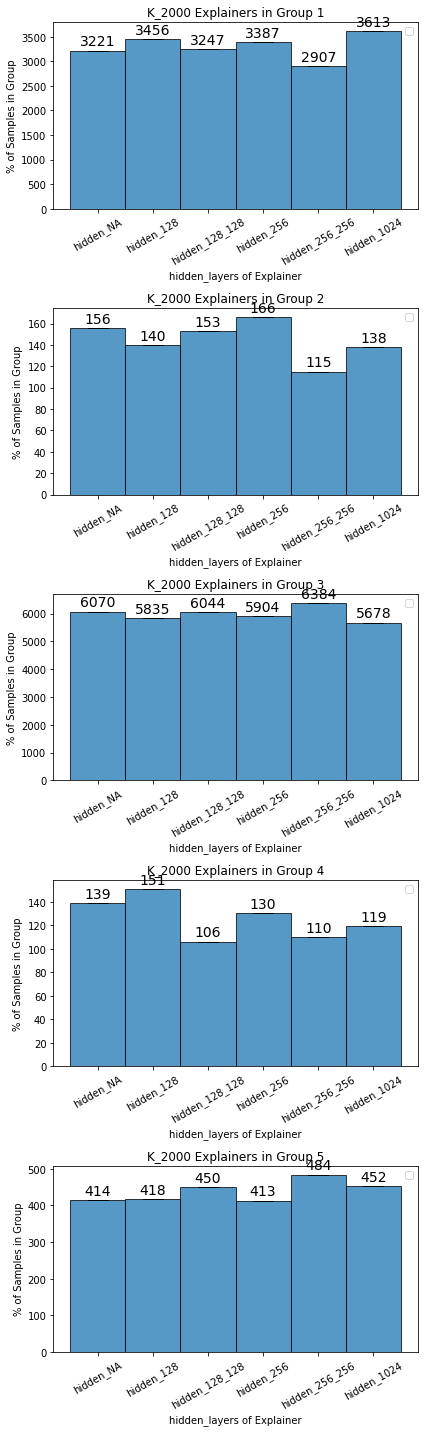

In [119]:
# Make separate bar graphs for each case
filter_phrase = 'K_2000'
xlabel_separation = 'hidden_layers'
temp_df = summary_df[summary_df['ids'].str.contains(filter_phrase, regex=True)]
n_rows = len(temp_df)
# from utils.visualizations import bar_graph
fig, axs = plt.subplots(5, 1, figsize=(6, 20))
for case_idx in range(1, 6):
    case_counts = temp_df['case{}'.format(case_idx)].to_numpy()
    case_counts = [int(count) for count in case_counts]
    
        
    fig, axs[case_idx-1] = bar_graph(
        data=[case_counts],
        fig=fig,
        ax=axs[case_idx-1],
        display_values=True,
        labels=labels,
        xlabel='{} of Explainer'.format(xlabel_separation),
        xlabel_rotation=30,
        ylabel='% of Samples in Group',
        title='{} Explainers in Group {}'.format(filter_phrase, case_idx),
        show=False,
        save_path=None)
    
save_path = os.path.join(vis_save_dir, '{}_group_percentages.png'.format(filter_phrase))
plt.savefig(save_path)
print("Saved bar plots to {}".format(save_path))
plt.show()
plt.close()

#### Make 2 barplots:
* % of explainer alignment when the model is correct (out of all samples model is correct)
* % of explainer alignment when the model is incorrect (out of all samples model is incorrect)filter_phrase = 'K_2000'
xlabel_separation = 'hidden_layers'
temp_df = summary_df[summary_df['ids'].str.contains(filter_phrase, regex=True)]
n_rows = len(temp_df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

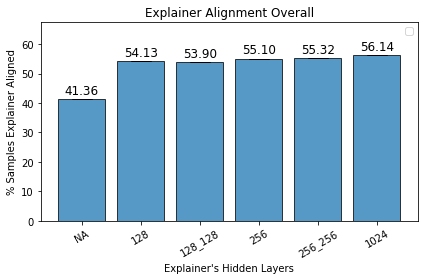

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

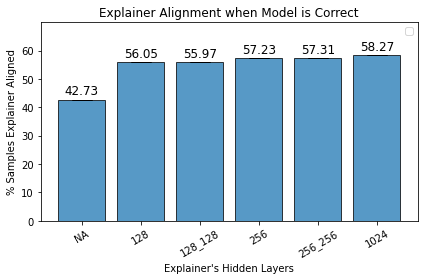

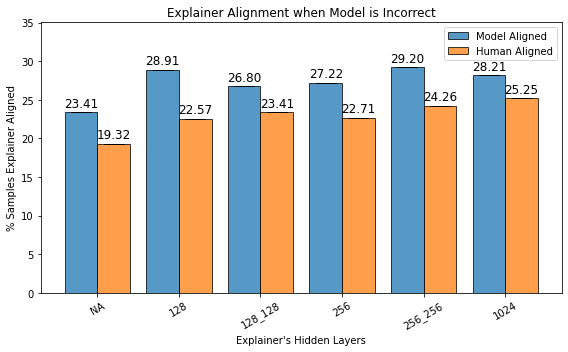

<Figure size 432x288 with 0 Axes>

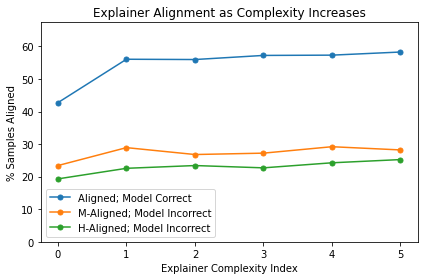

"\n# Plotting human and model alignment on different axes\nfig, axs = plt.subplots(2, 1, figsize=(6,5))\nfor idx, (data, agent) in enumerate(zip([m_aligned_percent, h_aligned_percent], ['Model', 'Human'])):\n    print(data)\n    fig, axs[idx] = bar_graph(\n        data=[data],\n        fig=fig,\n        ax=axs[idx],\n        display_values=True,\n        labels=labels,\n        xlabel_rotation=30,\n        ylim=[0, np.max(np.stack([m_aligned_percent, h_aligned_percent])) * 1.2],\n        # groups=['Model Aligned', 'Human Aligned'],\n        xlabel=xlabel,\n        ylabel=ylabel,\n        title='{}-Explainer Alignment when Model is Incorrect'.format(agent),\n        show=False)\nplt.show()\n"

In [178]:
filter_phrase = 'RGB'
xlabel_separation = 'hidden_layers'
temp_df = summary_df[summary_df['ids'].str.contains(filter_phrase, regex=True)]
n_rows = len(temp_df)
if xlabel_separation == 'input_type':
    labels = [os.path.basename(os.path.dirname(path)) for path in temp_df['ids']]
elif xlabel_separation == 'hidden_layers':
    # labels = [os.path.basename(path) for path in temp_df['ids']]
    labels = []
    for path in temp_df['ids']:
        label = os.path.basename(path)
        label = path.split('hidden_')[1]
        labels.append(label)
else:
    raise ValueError("xlabel_separation '{}' not supported".format(xlabel_separation))
# Set axis labels
ylabel = '% Samples Explainer Aligned'
xlabel = "Explainer's Hidden Layers"

# Create save_paths
save_dir = os.path.join('saved_explainers/cifar/graphs/incr_params_explainer_alignment')
ensure_dir(save_dir)
overall_e_alignment_save_path = os.path.join(save_dir, '{}_overall_e_alignment.png'.format(filter_phrase))
model_correct_save_path = os.path.join(save_dir, '{}_m_correct.png'.format(filter_phrase))
model_incorrect_save_path = os.path.join(save_dir, '{}_m_incorrect.png'.format(filter_phrase))
all_line_plot_save_path = os.path.join(save_dir, '{}_all_line_plot.png'.format(filter_phrase))

# Overall Explainer alignment (across both groups)
overall_e_alignment = temp_df['overall_me_alignment'].to_numpy() * 100
bar_graph(
    data=[overall_e_alignment],
    display_values=True,
    labels=labels,
    xlabel_rotation=30,
    ylim=[0, np.max(overall_e_alignment) * 1.2],
    ylabel=ylabel,
    xlabel=xlabel,
    title='Explainer Alignment Overall',
    save_path=overall_e_alignment_save_path)


# When model is correct
case_counts = temp_df['case1'].to_numpy()
n_model_correct = temp_df['case1'].to_numpy() + temp_df['case3'].to_numpy()
e_aligned_m_correct_percent = case_counts / n_model_correct * 100
bar_graph(
    data=[e_aligned_m_correct_percent],
    display_values=True,
    labels=labels,
    xlabel_rotation=30,
    ylim=[0, np.max(e_aligned_m_correct_percent) * 1.20],
    ylabel=ylabel,
    xlabel=xlabel,
    title='Explainer Alignment when Model is Correct',
    save_path=model_correct_save_path)


# When model is incorrect
m_aligned_counts = temp_df['case2'].to_numpy()
h_aligned_counts = temp_df['case4'].to_numpy()
n_model_incorrect = temp_df['case2'].to_numpy() + temp_df['case4'].to_numpy() + temp_df['case5'].to_numpy()
m_aligned_percent = m_aligned_counts / n_model_incorrect * 100
h_aligned_percent = h_aligned_counts / n_model_incorrect * 100

fig, ax = plt.subplots(figsize=(8,5))
bar_graph(
    data=[m_aligned_percent, h_aligned_percent],
    fig=fig,
    ax=ax,
    display_values=True,
    labels=labels,
    xlabel_rotation=30,
    ylim=[0, np.max(np.stack([m_aligned_percent, h_aligned_percent])) * 1.2],
    groups=['Model Aligned', 'Human Aligned'],
    xlabel=xlabel,
    ylabel=ylabel,
    title='Explainer Alignment when Model is Incorrect',
    save_path=model_incorrect_save_path)
plt.close()

plot(
    xs=[[i for i in range(len(overall_e_alignment))] for j in range(3)],
    ys=[e_aligned_m_correct_percent, m_aligned_percent, h_aligned_percent],
    labels=['Aligned; Model Correct', 'M-Aligned; Model Incorrect', 'H-Aligned; Model Incorrect'],
    ylimits=[0,  np.max(overall_e_alignment) * 1.2],
    xlabel='Explainer Complexity Index',
    ylabel='% Samples Aligned',
    title='Explainer Alignment as Complexity Increases',
    show=True,
    save_path=all_line_plot_save_path)
'''
# Plotting human and model alignment on different axes
fig, axs = plt.subplots(2, 1, figsize=(6,5))
for idx, (data, agent) in enumerate(zip([m_aligned_percent, h_aligned_percent], ['Model', 'Human'])):
    print(data)
    fig, axs[idx] = bar_graph(
        data=[data],
        fig=fig,
        ax=axs[idx],
        display_values=True,
        labels=labels,
        xlabel_rotation=30,
        ylim=[0, np.max(np.stack([m_aligned_percent, h_aligned_percent])) * 1.2],
        # groups=['Model Aligned', 'Human Aligned'],
        xlabel=xlabel,
        ylabel=ylabel,
        title='{}-Explainer Alignment when Model is Incorrect'.format(agent),
        show=False)
plt.show()
'''

#### Display pie chart of 5 way break down (partitioned into model correct and model incorrect) for a specific explainer

<Figure size 432x288 with 0 Axes>

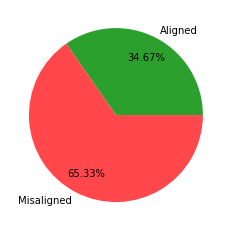

<Figure size 432x288 with 0 Axes>

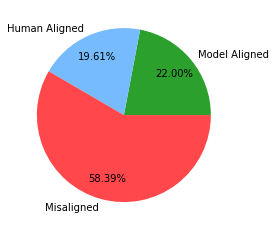

Saved pie chart for explainer alignment when model is correct to saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA/graphs/model_correct_explainer_alignment_pie.png
Saved pie chart for explainer alignment when model is incorrect to saved_explainers/cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA/graphs/model_incorrect_explainer_alignment_pie.png


In [95]:
from utils.visualizations import pie_chart
explainer_id = 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA'
save_dir = os.path.join('saved_explainers', explainer_id, 'graphs')
row = summary_df[summary_df['ids'] == explainer_id]
assert len(row) == 1

def explainer_alignment_pie_chart(row, save_dir=None):
    ensure_dir(save_dir)
    model_correct_save_path = os.path.join(save_dir, 'model_correct_explainer_alignment_pie.png')
    model_incorrect_save_path = os.path.join(save_dir, 'model_incorrect_explainer_alignment_pie.png')
    sizes = []
    for i in range(1, 6):
        sizes.append(row['case{}'.format(i)].values[0])

    model_correct_sizes = [sizes[0], sizes[2]]
    model_correct_labels = ['Aligned', 'Misaligned']

    pie_chart(sizes=model_correct_sizes,
              labels=model_correct_labels,
              colors=['tab:green', 'xkcd:light red'],
              show=True,
              save_path=model_correct_save_path)

    model_incorrect_sizes = [sizes[1], sizes[3], sizes[4]]
    model_incorrect_labels = [
        'Model Aligned',
        'Human Aligned',
        'Misaligned'
    ]
    pie_chart(sizes=model_incorrect_sizes,
              labels=model_incorrect_labels,
              colors=['tab:green', 'xkcd:sky blue', 'xkcd:light red'],
              show=True,
              save_path=model_incorrect_save_path)
    print("Saved pie chart for explainer alignment when model is correct to {}".format(model_correct_save_path))
    print("Saved pie chart for explainer alignment when model is incorrect to {}".format(model_incorrect_save_path))
    
explainer_alignment_pie_chart(
    row=row,
    save_dir=save_dir)
                     

In [40]:
def calculate_1_3_migration(from_df, 
                            to_df,
                            from_id, 
                            to_id,
                            silent=False,
                            run_asserts=True):
    migration_dict = {
        'from': from_id,
        'to': to_id
    }
    
    # Obtain idxs for groups 1,3 in both dataframes
    from_1_idxs = from_df[from_df['case1'] == True]['image_idxs']
    from_3_idxs = from_df[from_df['case3'] == True]['image_idxs']
    to_1_idxs = to_df[to_df['case1'] == True]['image_idxs']
    to_3_idxs = to_df[to_df['case3'] == True]['image_idxs']
    
    if run_asserts:
        assert len(from_1_idxs) == len(set(from_1_idxs))
        assert len(from_3_idxs) == len(set(from_3_idxs))
        assert len(to_1_idxs) == len(set(to_1_idxs))
        assert len(to_3_idxs) == len(set(to_3_idxs))
        
    # Convert to sets
    from_1_idxs = set(from_1_idxs)
    from_3_idxs = set(from_3_idxs)
    to_1_idxs = set(to_1_idxs)
    to_3_idxs = set(to_3_idxs)
    
    n_from_1 = len(from_1_idxs)
    n_from_3 = len(from_3_idxs)
    n_to_1 = len(to_1_idxs)
    n_to_3 = len(to_3_idxs)
    
    assert n_from_1 + n_from_3 == n_to_1 + n_to_3
    
    # Count number of samples that migrated from 1->3
    n_1_3 = len(from_1_idxs.intersection(to_3_idxs))        
    # Count number of samples that stayed 1->1
    n_1_1 = len(from_1_idxs.intersection(to_1_idxs))        
    # Count number of samples that migrated from 3->1
    n_3_1 = len(from_3_idxs.intersection(to_1_idxs))        

    # Count number of samples that stayed 3->3
    n_3_3 = len(from_3_idxs.intersection(to_3_idxs))
    
    if not silent:
        print("1 -> 3: {} samples".format(n_1_3))
        print("1 -> 1: {} samples".format(n_1_1))
        print("3 -> 1: {} samples".format(n_3_1))
        print("3 -> 3: {} samples".format(n_3_3))
        
    migration_dict.update({
        'from_1': n_from_1,
        'from_3': n_from_3,
        'to_1': n_to_1,
        'to_3': n_to_3,
        '1_3': n_1_3,
        '3_1': n_3_1,
        '1_1': n_1_1,
        '3_3': n_3_3
    })
    
    # Calculate metrics based on counts
    alignment_migration_ratio = n_3_1 / n_1_3  # higher is better
    ioo_1 = n_1_1 / (n_1_1 + n_1_3)  # higher is better
    ioo_3 = n_3_3 / (n_3_3 + n_3_1)  # lower is better
    net_change = n_3_1 - n_1_3
    total_change = n_3_1 + n_1_3
    
    if not silent:
        print("alignment migration ratio (H): {:.3f}".format(alignment_migration_ratio))
        print("IOO 1 (H): {:3f}".format(ioo_1))
        print("IOO 3 (L): {:.3f}".format(ioo_3))
        print("Net change: {} samples".format(net_change))
    migration_dict.update({
        '1_3_alignment_migration_ratio':alignment_migration_ratio,
        'ioo_1': ioo_1,
        'ioo_3': ioo_3,
        '1_3_net_change': net_change,
        '1_3_net_change_percent': net_change / (n_from_3 + n_from_1),
        '1_3_total_change': total_change,
        '1_3_total_change_percent': total_change / (n_from_3 + n_from_1),
        '1_3_net_total_change_ratio': net_change / total_change
    })
    return migration_dict

def calculate_2_4_5_migration(from_df, 
                              to_df,
                              from_id, 
                              to_id,
                              silent=False,
                              run_asserts=True):
    migration_dict = {
        'from': from_id,
        'to': to_id
    }
    
    # Obtain idxs for groups 2,4,5 in both dataframes
    from_2_idxs = from_df[from_df['case2'] == True]['image_idxs']
    from_4_idxs = from_df[from_df['case4'] == True]['image_idxs']
    from_5_idxs = from_df[from_df['case5'] == True]['image_idxs']
    to_2_idxs = to_df[to_df['case2'] == True]['image_idxs']
    to_4_idxs = to_df[to_df['case4'] == True]['image_idxs']
    to_5_idxs = to_df[to_df['case5'] == True]['image_idxs']
    
    if run_asserts:
        assert len(from_2_idxs) == len(set(from_2_idxs))
        assert len(from_4_idxs) == len(set(from_4_idxs))
        assert len(from_5_idxs) == len(set(from_5_idxs))
        assert len(to_2_idxs) == len(set(to_2_idxs))
        assert len(to_4_idxs) == len(set(to_4_idxs))
        assert len(to_5_idxs) == len(set(to_5_idxs))
        
    # Convert to sets
    from_2_idxs = set(from_2_idxs)
    from_4_idxs = set(from_4_idxs)
    from_5_idxs = set(from_5_idxs)
    to_2_idxs = set(to_2_idxs)
    to_4_idxs = set(to_4_idxs)
    to_5_idxs = set(to_5_idxs)
    
    # Count number in each group
    n_from_2 = len(from_2_idxs)
    n_from_4 = len(from_4_idxs)
    n_from_5 = len(from_5_idxs)
    n_to_2 = len(to_2_idxs)
    n_to_4 = len(to_4_idxs)
    n_to_5 = len(to_5_idxs)
    
    # Count migration patterns
    # Count number of samples from 2 -> 5
    n_2_5 = len(from_2_idxs.intersection(to_5_idxs))
    # Count number of samples from 2 -> 4
    n_2_4 = len(from_2_idxs.intersection(to_4_idxs))
    
    # Count number of samples from 4 -> 2
    n_4_2 = len(from_4_idxs.intersection(to_2_idxs))
    # Count number of samples from 4 -> 5
    n_4_5 = len(from_4_idxs.intersection(to_5_idxs))
    
    
    # Count number of samples from 5 -> 2
    n_5_2 = len(from_5_idxs.intersection(to_2_idxs))
    # Count number of samples from 5 -> 4
    n_5_4 = len(from_5_idxs.intersection(to_4_idxs))
    
    n_total_2_4_5 = n_from_2 + n_from_4 + n_from_5
    assert n_total_2_4_5 == n_to_2 + n_to_4 + n_to_5

    if not silent:
        print("2 -> 4: {} samples".format(n_2_4))
        print("2 -> 5: {} samples".format(n_2_5))
        print("4 -> 2: {} samples".format(n_4_2))
        print("4 -> 5: {} samples".format(n_4_5))
        print("5 -> 2: {} samples".format(n_5_2))
        print("5 -> 4: {} samples".format(n_5_4))
    
    migration_dict.update({
        'from_2': n_from_2,
        'from_4': n_from_4,
        'from_5': n_from_5,
        'to_2': n_to_2,
        'to_4': n_to_4,
        'to_5': n_to_5,
        '2_5': n_2_5,
        '2_4': n_2_4,
        '4_2': n_4_2,
        '4_5': n_4_5,
        '5_2': n_5_2,
        '5_4': n_5_4
    })
    
    model_net_change = n_5_2 + n_4_2 - n_2_5 - n_2_4
    human_net_change = n_5_4 + n_2_4 - n_4_5 - n_4_2
    alignment_net_change = n_5_4 + n_5_2 - n_4_5 - n_2_5
    total_change = n_2_5 + n_2_4 + n_4_2 + n_4_5 + n_5_2 + n_5_4
    
    n_model_net_change_percent = model_net_change / n_total_2_4_5
    n_human_net_change_percent = human_net_change / n_total_2_4_5
    n_alignment_net_change_percent = alignment_net_change / n_total_2_4_5
    
    model_migration_ratio = (n_5_2 + n_4_2) / (n_2_5 + n_2_4)
    human_migration_ratio = (n_5_4 + n_2_4) / (n_4_5 + n_4_2)
    alignment_migration_ratio = (n_5_4 + n_5_2) / (n_4_5 + n_2_5)
    
    if not silent:
        print("2_4_5_model_net_change: {} samples".format(model_net_change))
        print("2_4_5_human_net_change: {} samples".format(human_net_change))
        print("2_4_5_alignment_net_change: {} samples".format(alignment_net_change))

        print("2_4_5_model_net_change: {:.2f}%".format(n_model_net_change_percent * 100))
        print("2_4_5_human_net_change: {:.2f}%".format(n_human_net_change_percent * 100))
        print("2_4_5_alignment_net_change: {:.2f}%".format(n_alignment_net_change_percent * 100))
        
        print("2_4_5_model_migration_ratio: {}".format(model_migration_ratio))
        print("2_4_5_human_migration_ratio: {}".format(human_migration_ratio))
        print("2_4_5_alignment_migration_ratio: {}".format(alignment_migration_ratio))
    
    migration_dict.update({
        '2_4_5_model_net_change': model_net_change,
        '2_4_5_human_net_change': human_net_change,
        '2_4_5_alignment_net_change': alignment_net_change,
        '2_4_5_model_net_change_percent': n_model_net_change_percent,
        '2_4_5_human_net_change_percent': n_human_net_change_percent,
        '2_4_5_alignment_net_change_percent': n_alignment_net_change_percent,
        '2_4_5_model_migration_ratio': model_migration_ratio,
        '2_4_5_human_migration_ratio': human_migration_ratio,
        '2_4_5_alignment_migration_ratio': alignment_migration_ratio
        
    })
    return migration_dict


In [102]:
silent = True
constant_types_available = ['RGB', 'intensity', 'SIFT500', 'SIFT2000']
constant = 'SIFT2000'
assert constant in constant_types_available
if constant == 'RGB':
    # Constant: RGB input type
    pair_ids = [
        ('cifar/pixel/RGB/hidden_NA', 'cifar/pixel/RGB/hidden_128'),
        ('cifar/pixel/RGB/hidden_NA', 'cifar/pixel/RGB/hidden_128_128'),
        ('cifar/pixel/RGB/hidden_NA', 'cifar/pixel/RGB/hidden_256'),
        ('cifar/pixel/RGB/hidden_NA', 'cifar/pixel/RGB/hidden_256_256'),
        ('cifar/pixel/RGB/hidden_NA', 'cifar/pixel/RGB/hidden_1024'),
    ]
elif constant == 'intensity':
    # Constant: Intensity input type
    pair_ids = [
        ('cifar/pixel/intensity/hidden_NA', 'cifar/pixel/intensity/hidden_128'),
        ('cifar/pixel/intensity/hidden_NA', 'cifar/pixel/intensity/hidden_128_128'),
        ('cifar/pixel/intensity/hidden_NA', 'cifar/pixel/intensity/hidden_256'),
        ('cifar/pixel/intensity/hidden_NA', 'cifar/pixel/intensity/hidden_256_256'),
        ('cifar/pixel/intensity/hidden_NA', 'cifar/pixel/intensity/hidden_1024'),
    ]
elif constant == 'SIFT500':
    # Constant: SIFT500 input type
    pair_ids = [
        ('cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128'),
        ('cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_128_128'),
        ('cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256'),
        ('cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_256_256'),
        ('cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_500/hidden_1024'),
    ]
elif constant == 'SIFT2000':
    # Constant: SIFT2000 input type
    pair_ids = [
        ('cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128'),
        ('cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128_128'),
        ('cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256'),
        ('cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256_256'),
        ('cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA', 'cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_1024'),
    ]

migration_df_dicts = []
for from_id, to_id in pair_ids:
    from_idx = explainer_id_dict[from_id]
    from_df = results_dfs[from_idx]
    
    to_idx = explainer_id_dict[to_id]
    to_df = results_dfs[to_idx]
    
    if not silent:
        print("Calculating migration from {} to {}".format(from_id, to_id))
    migration_dict = calculate_1_3_migration(
        from_df=from_df,
        to_df=to_df,
        from_id=from_id,
        to_id=to_id,
        silent=silent)
    
    migration_dict.update(calculate_2_4_5_migration(
        from_df=from_df,
        to_df=to_df,
        from_id=from_id,
        to_id=to_id,
        silent=silent))
    migration_df_dicts.append(migration_dict)
    if not silent:
        print("")
migration_df = pd.DataFrame(migration_df_dicts)
print("Created migration DF for {}".format(constant))

Created migration DF for SIFT2000


In [104]:
save_dir = os.path.join('saved_explainers', 'cifar')
migration_df_save_path = os.path.join(save_dir, 'migration_{}.csv'.format(constant))
save_csv(migration_df, migration_df_save_path)
print(migration_df)


Saved migration_df to saved_explainers/cifar/migration_SIFT2000.csv
                                             from   
0  cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA  \
1  cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA   
2  cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA   
3  cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA   
4  cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_NA   

                                                  to  from_1  from_3  to_1   
0    cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_128    3221    6070  3456  \
1  cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_12...    3221    6070  3247   
2    cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_256    3221    6070  3387   
3  cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_25...    3221    6070  2907   
4   cifar/SIFT/sigma_1.6/stride_2/K_2000/hidden_1024    3221    6070  3613   

   to_3   1_3   3_1   1_1   3_3  ...  5_4  2_4_5_model_net_change   
0  5835  1411  1646  1810  4424  ...   56                     -16  \
1  604

saved plot to saved_explainers/cifar/graphs/['2_4_5_human_migration_ratio']_v_Complexity Index_for_K_2000


<Figure size 432x288 with 0 Axes>

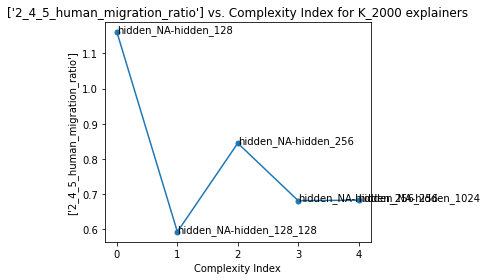

In [107]:
xlabel = 'Complexity Index'
# xlabel = 'total_change_percent'
# ylabels = ['net_change_percent', 'total_change_percent']
ylabels = ['2_4_5_human_migration_ratio']
constant = 'K_2000'

# verify constant in all paths
for f, t in zip(migration_df['from'], migration_df['to']):
    assert constant in f and constant in t, "constant {} not found in from ({}) or to({})".format(constant, f, t)
if xlabel == 'Complexity Index':
    xs = [[i for i in range(len(migration_df))] for itr in range(len(ylabels))]
    ys = [migration_df[ylab].to_numpy() for ylab in ylabels]
    froms = migration_df['from'].to_list()
    tos = migration_df['to'].to_list()
    point_annotations = ['{}-{}'.format(os.path.basename(f), os.path.basename(t)) for f, t in zip(froms, tos)]
else:
    sorted_migration_df = migration_df.sort_values(xlabel)
    xs = [sorted_migration_df[xlabel].to_numpy() for ylab in ylabels]
    ys = [sorted_migration_df[ylab].to_numpy() for ylab in ylabels]
    froms = sorted_migration_df['from'].to_list()
    tos = sorted_migration_df['to'].to_list()
    point_annotations = ['{}-{}'.format(os.path.basename(f), os.path.basename(t)) for f, t in zip(froms, tos)]



plot_save_path = os.path.join(vis_save_dir, '{}_v_{}_for_{}'.format(ylabels, xlabel, constant))
plot(
    xs=xs,
    ys=ys,
    point_annotations=[point_annotations for i in range(len(ylabels))],
    xlabel=xlabel,
    ylabel=ylabels,
    title='{} vs. {} for {} explainers'.format(ylabels, xlabel, constant),
    save_path=plot_save_path)
print("saved plot to {}".format(plot_save_path))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 432x288 with 0 Axes>

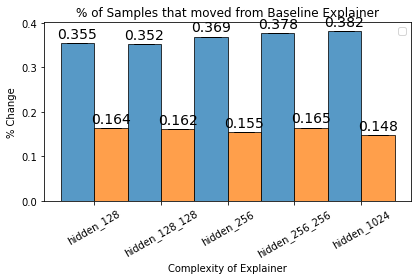

(<Figure size 432x288 with 1 Axes>,
 <Axes: title={'center': '% of Samples that moved from Baseline Explainer'}, xlabel='Complexity of Explainer', ylabel='% Change'>)

In [54]:
# Graph % samples from 3->1 and 1->3
percent_3_1 = migration_df['3_1'] / (migration_df['from_3'])
percent_1_3 = migration_df['1_3'] / migration_df['from_1']
labels = [os.path.basename(to_exp) for to_exp in migration_df['to']]
bar_graph(
    data=[percent_3_1, percent_1_3],
    display_values=True,
    # groups=['% Become Aligned', '% Become Misaligned'],
    labels=labels,
    xlabel='Complexity of Explainer',
    ylabel='% Change',
    title='% of Samples that moved from Baseline Explainer',
    xlabel_rotation=30)
    


## Make separate CSVs

In [185]:
dataset = 'ADE20K'
datasets_available = ['cifar', 'ADE20K']
assert dataset in datasets_available

if dataset == 'cifar':
    master_csv_path = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/pixel_explainer.csv'
    n_classes = 10
elif dataset == 'ADE20K':
    master_csv_path = 'saved/ADE20K/survey_results/processed_results_300_samples.csv'
    n_classes = 16
else:
    raise ValueError("Dataset '{}' unsupported. Try {}".format(dataset, datasets_available))
assert dataset in master_csv_path

In [163]:
# Make separate CSVs from master CSV
df = pd.read_csv(master_csv_path)
string_column_templates = ['{}_probabilities', '{}_outputs']
agents = ['human', 'model', 'explainer']
string_columns = []
for agent in agents:
    for template in string_column_templates:
        string_columns.append(template.format(agent))
df = convert_string_columns(
    df=df,
    columns=string_columns)
print("Read master CSV from {}".format(master_csv_path))
      
groups_save_dir = os.path.join(os.path.dirname(master_csv_path), 'group_csvs')
ensure_dir(groups_save_dir)

# Check if filenames are in the save directory
n_groups = 5
filenames = ['group_{}.csv'.format(i) for i in range(1, 6)]
dir_contents = os.listdir(groups_save_dir)
dir_empty = True
for file in filenames:
    if file in dir_contents:
        dir_empty = False
if False: #not dir_empty:
    print("Directory {} is not empty. Remove contents to save group CSVs".format(groups_save_dir))
else:
    dfs = []
    # Case 1: model = explainer = human 
    df1 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] == df['human_predictions'])]
    dfs.append(df1)
    # Case 2: model = explainer != human
    df2 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
    dfs.append(df2)

    # Case 3: model = human != explainer
    df3 = df[(df['model_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
    dfs.append(df3)

    # Case 4: explainer = human != model
    df4 = df[(df['explainer_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
    dfs.append(df4)

    # Case 5: explainer != model != human
    df5 = df[(df['explainer_predictions'] != df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
    dfs.append(df5)

    # Check that no rows overlap, all mutually exclusive
    for i in range(len(dfs) - 1):
        for j in range(i+1, len(dfs)):
            overlap = set(dfs[i].index) & set(dfs[j].index)
            assert len(overlap) == 0
    for idx, cur_df in enumerate(dfs):
        cur_csv_save_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(idx+1))
        cur_df.to_csv(cur_csv_save_path)
        print("Saved CSV for group {} to {}".format(idx+1, cur_csv_save_path))

Read master CSV from saved/ADE20K/survey_results/processed_results_300_samples.csv
Saved CSV for group 1 to saved/ADE20K/survey_results/group_csvs/group_1.csv
Saved CSV for group 2 to saved/ADE20K/survey_results/group_csvs/group_2.csv
Saved CSV for group 3 to saved/ADE20K/survey_results/group_csvs/group_3.csv
Saved CSV for group 4 to saved/ADE20K/survey_results/group_csvs/group_4.csv
Saved CSV for group 5 to saved/ADE20K/survey_results/group_csvs/group_5.csv


In [164]:
# group_nums = [1, 3]  # model and human are aligned
group_nums = [2, 4, 5]

cur_df_list = []
for group_num in group_nums:
    csv_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(group_num))
    cur_df_list.append(pd.read_csv(csv_path))
    cur_df = pd.concat(cur_df_list)

print("Joined groups {} to form dataframe with {} rows".format(group_nums, len(cur_df)))

# Make directory for this grouping
group_name = 'group'
for i in group_nums:
    group_name += '_{}'.format(i)
cur_group_save_dir = os.path.join(groups_save_dir, group_name)
ensure_dir(cur_group_save_dir)
print("Created directory for groups {} at {}".format(group_nums, cur_group_save_dir))
graph_save_dir = os.path.join(cur_group_save_dir, 'graphs')
ensure_dir(graph_save_dir)
print("Created directory for graphs at {}".format(group_nums, cur_group_save_dir))

# Save current dataframe
cur_csv_save_path = os.path.join(cur_group_save_dir, '{}.csv'.format(group_name))
if not os.path.exists(cur_csv_save_path):
    cur_df.to_csv(cur_csv_save_path)
    print("Saved csv for groups {} at {}".format(group_nums, cur_csv_save_path))
else:
    print("CSV at {} already exists.".format(cur_csv_save_path))

Joined groups [2, 4, 5] to form dataframe with 106 rows
Created directory for groups [2, 4, 5] at saved/ADE20K/survey_results/group_csvs/group_2_4_5
Created directory for graphs at [2, 4, 5]
CSV at saved/ADE20K/survey_results/group_csvs/group_2_4_5/group_2_4_5.csv already exists.


# Process

#### sensitivity of number of bins on R-squared

['case1', 'case3']
n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

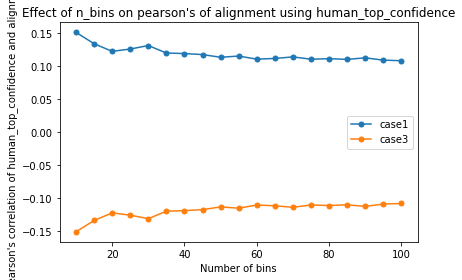

<Figure size 432x288 with 0 Axes>

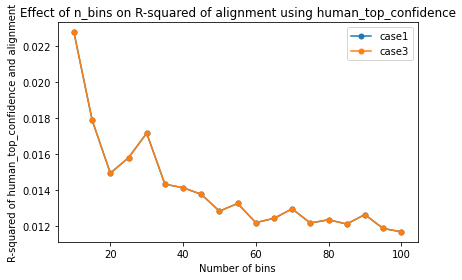

['case1', 'case3']
n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

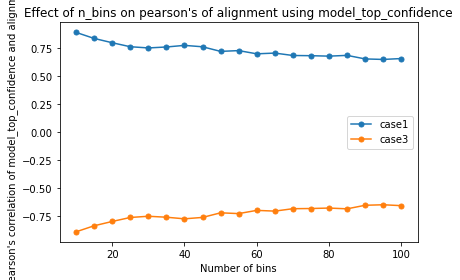

<Figure size 432x288 with 0 Axes>

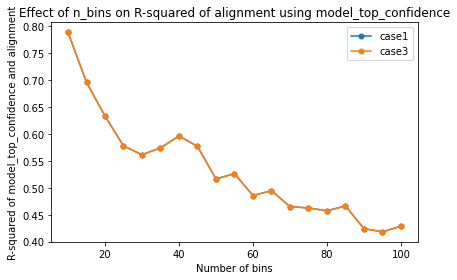

['case1', 'case3']
n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

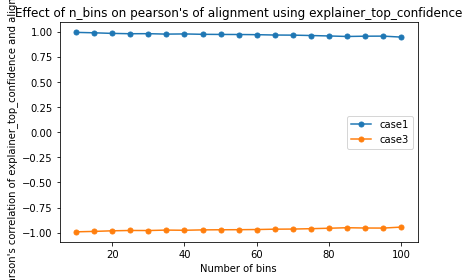

<Figure size 432x288 with 0 Axes>

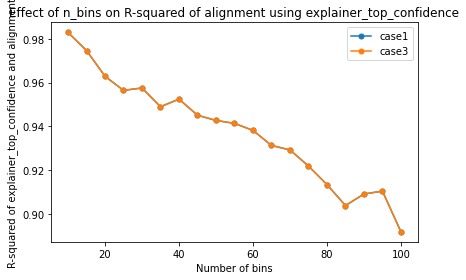

In [8]:
sensitivity_graph_save_dir = os.path.join(graph_save_dir, 'n_bin_sensitivity')
ensure_dir(sensitivity_graph_save_dir)
for iv_agent in ['human', 'model', 'explainer']:
    iv_names = ['{}_top_confidence'.format(iv_agent),
                '{}_t2c'.format(iv_agent),
                '{}_entropy'.format(iv_agent)]
    # agent_pairs = [
    #     ('human', 'explainer'),
    #     ('human', 'model'),
    #     ('model', 'explainer')]
    cases = ['case{}'.format(i) for i in group_nums]
    print(cases)
    
    all_pearsons = []
    all_r_squared = []
    n_bins = [i for i in range(10, 101, 5)]
    print("n_bins: {}".format(n_bins))

    for case_idx, case in enumerate(cases):
        # agent1, agent2 = pair
        cur_pearsons = []
        cur_r_squared = []
        for n_bin in n_bins:
            bin_rows, iv_means, iv_stds, iv_ses = sort_and_bin_df(
                df=cur_df,
                sort_columns=iv_names, 
                n_bins=n_bin)
            cur_agreements, agreement_stds, agreement_ses = calculate_bin_agreement(
                bin_rows=bin_rows,
                column_name=case)
            pearsons = stats.pearsonr(iv_means, cur_agreements).statistic
            cur_pearsons.append(pearsons)
            # slope, yint, r, p, std_err = stats.linregress(iv_means, cur_agreement)
            r_squared = pearsons ** 2
            cur_r_squared.append(r_squared)
        all_pearsons.append(cur_pearsons)
        all_r_squared.append(cur_r_squared)

    # Plot pearsons v n_bins
    plot(
        xs=[n_bins for i in range(len(cases))],
        ys=all_pearsons,
        labels=cases,
        xlabel='Number of bins',
        ylabel="Pearson's correlation of {} and alignment".format(iv_names[0]),
        title='Effect of n_bins on pearson\'s of alignment using {}'.format(
            iv_names[0]),
        show=True,
        save_path=os.path.join(sensitivity_graph_save_dir, 'nbins_pearsons_{}.png'.format(iv_names[0])))


    # Plot r-squared v n_bins
    plot(
        xs=[n_bins for i in range(len(cases))],
        ys=all_r_squared,
        labels=cases,
        xlabel='Number of bins',
        ylabel="R-squared of {} and alignment".format(iv_names[0]),
        title='Effect of n_bins on R-squared of alignment using {}'.format(
            iv_names[0]),
        show=True,
        save_path=os.path.join(sensitivity_graph_save_dir, 'nbins_rsquared_{}.png'.format(iv_names[0])))

#### Linear Regression

Figure saved to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_1_3/graphs/human-explainer_alignment_v_t2c.png


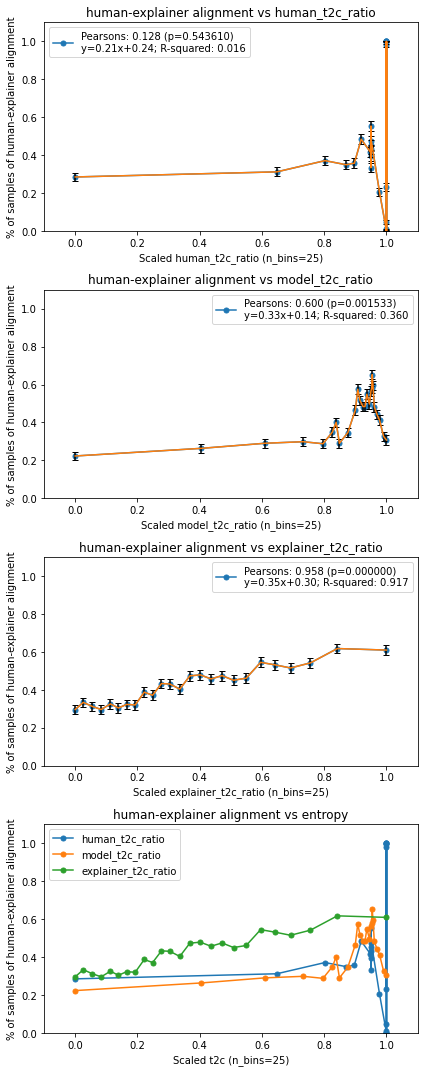

Figure saved to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_1_3/graphs/model-explainer_alignment_v_t2c.png


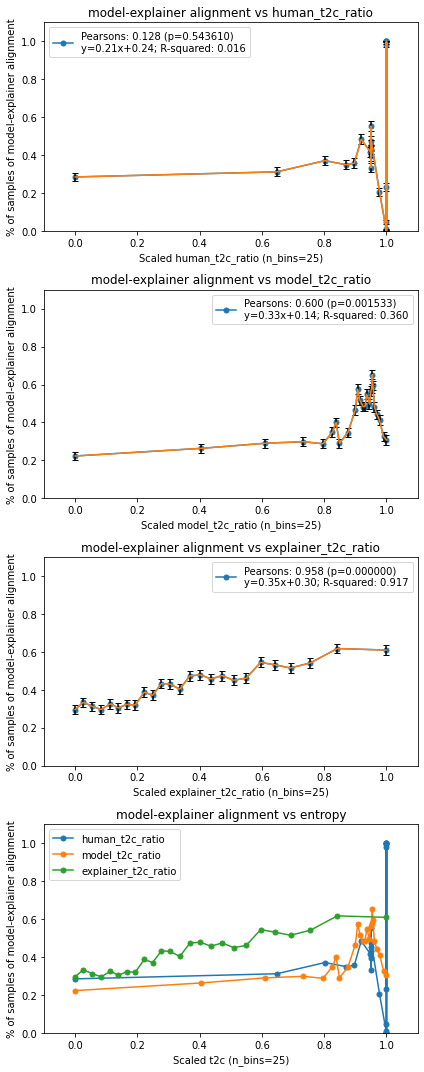

Pearsons between variance of confusion and variance of alignment: 0.092 (p=0.262501)
y=0.02x+0.02; R-squared: 0.008


In [18]:
agent_pairs = [
    ('human', 'explainer'),
    # ('human', 'model'),
    ('model', 'explainer')
]
agents = ['human', 'model', 'explainer']

plot_xerr = False
plot_yerr = True

# confusion_templates = ['{}_entropy', '{}_t2c']
# confusion_templates = ['{}_t2c', '{}_entropy']
confusion_templates = ['{}_t2c_ratio']
# confusion_templates = ['{}_top_confidence', '{}_t2c', '{}_entropy']
x_variance = []
y_variance = []
if 'entropy' in confusion_templates[0]:
    n_bins = 20
elif 't2c' in confusion_templates[0]:
    n_bins = 25
elif 'top_confidence' in confusion_templates[0]:
    n_bins = 25
else:
    raise ValueError("Confusion type in '{}' not supported.".format(confusion_templates[0]))
for agent_pair in agent_pairs:
    agent1, agent2 = agent_pair
    confusions = []
    agreements = []
    fig, axs = plt.subplots(4, 1, figsize=(6, 15))
    
    # Separate plot for confusion from each agent
    for idx, agent in enumerate(agents):
        confusion_names = [confusion_template.format(agent) for confusion_template in confusion_templates]
        ax, iv_means, iv_stds, cur_agreement, agreement_ses, ylabel = plot_alignment(
            df=cur_df,
            confusion_names=confusion_names,
            n_bins=n_bins,
            fig=fig,
            ax=axs[idx],
            alignment_col_name=None,
            agent1=agent1,
            agent2=agent2,
            plot_xerr=plot_xerr,
            plot_yerr=plot_yerr)

        confusions.append(iv_means)
        agreements.append(cur_agreement)

        x_variance.append(iv_stds)
        y_variance.append(agreement_ses)
        axs[idx] = ax
    
    xlabel = 'Scaled {} (n_bins={})'.format(confusion_templates[0].split('_')[1], n_bins)
    title = '{}-{} alignment vs entropy'.format(agent1, agent2)
    fig, ax = plot(
        xs=confusions,
        ys=agreements,
        fig=fig,
        ax=axs[-1],
        labels=[confusion_templates[0].format(agent) for agent in agents],
        xlabel=xlabel,
        ylabel=ylabel,
        ylimits=[0, 1.1],
        xlimits=[-0.1, 1.1],
        title=title,
        show=False)
    axs[-1] = ax
    save_path = os.path.join(graph_save_dir, '{}-{}_alignment_v_{}.png'.format(agent1, agent2, confusion_templates[0].split('_')[1]))
    plt.savefig(save_path)
    print("Figure saved to {}".format(save_path))
    plt.show()
    
x_variance = np.concatenate(x_variance, axis=0)
y_variance = np.concatenate(y_variance, axis=0)

slope, yint, r, p, std_err = stats.linregress(
    x=x_variance,
    y=y_variance)
print('Pearsons between variance of confusion and variance of alignment: {:.3f} (p={:.6f})\ny={:.2f}x+{:.2f}; R-squared: {:.3f}'.format(
        r, p, slope, yint, r**2))


In [20]:
# Set constants
seed = 1
penalty = 'l2'
solver = 'lbfgs'
class_weight = 'balanced'
logistic_regression_args = {
    'penalty': penalty,
    'solver': solver,
    'class_weight': class_weight
}

metric_names = ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss']

# Split dataframe into train/test
train_split = 0.7
# shuffled = cur_df.sample(frac=1, random_state=seed)
train_rows = cur_df.sample(frac=train_split, random_state=seed)
print(train_rows['case1'][:5])
val_rows = cur_df.drop(train_rows.index)
assert len(set(train_rows.index).intersection(set(val_rows.index))) == 0

# Create x, y data
iv_types = ['top_confidence', 'entropy', 't2c']
agents = ['human', 'model', 'explainer']
agent_pairs = [
    ('human', 'explainer'),
    # ('model', 'explainer'),
    # ('human', 'model')
]

agents_list = [
    ['human'],
    ['model'],
    ['explainer'],
    ['human', 'explainer'],
    ['human', 'model'],
    ['model', 'explainer'],
    ['human', 'explainer', 'model']
]

for agent1, agent2 in agent_pairs:
    print("{}-{} alignment in training: {:.2f} \t in test: {:.2f}".format(
        agent1, agent2,
        100 * len(train_rows[train_rows['{}_{}_alignment'.format(agent1, agent2)] == 1]) / len(train_rows),
        100 * len(val_rows[val_rows['{}_{}_alignment'.format(agent1, agent2)] == 1]) / len(val_rows)))
        

3812    False
3402    False
3463     True
2874    False
1887    False
Name: case1, dtype: bool
human-explainer alignment in training: 42.67 	 in test: 31.81


In [21]:
# List to store results from all trials
trials = []
clfs = []
trial_keys = []
trial_idx = 1
n_trials = len(iv_types) * len(agents_list) * len(agent_pairs)
for iv_type in iv_types:
    for idx, agents in enumerate(agents_list):
        x_names = ['{}_{}'.format(agent, iv_type) for agent in agents]
        for x_name in x_names:
            assert x_name in cur_df.columns 
        
        for agent1, agent2 in agent_pairs:
            # set seed 
            seed = 0
            y_names = ['{}_{}_alignment'.format(agent1, agent2)]
            print("Itr {}/{}: IV: {} DV: {}".format(trial_idx, n_trials, x_names, y_names))
            trial_return = run_feature_importance_trial(
                train_rows=train_rows,
                val_rows=val_rows,
                x_names=x_names,
                y_names=y_names,
                metric_names=metric_names,
                trial_id=trial_idx-1,
                logistic_regression_args=logistic_regression_args,
                seed=seed)
            clf = trial_return['clf']
            cur_data = trial_return['cur_data']
            trial_key = trial_return['trial_key']
            
            clfs.append(clf)
            trials.append(cur_data)
            trial_keys.append(trial_key)
            trial_idx += 1


Itr 1/21: IV: ['human_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.4572687224669604 Regularization: 0.001
Best accuracy: 0.46079295154185024 Regularization: 0.1
Learned classifier to predict ['human_explainer_alignment'] from ['human_top_confidence']
Coefficients: [[1.0795193]]
Predictions:
0: 31.01
1: 68.99
Itr 2/21: IV: ['model_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.42466960352422906 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['model_top_confidence']
Coefficients: [[0.04026519]]
Predictions:
0: 15.42
1: 84.58
Itr 3/21: IV: ['explainer_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.6563876651982379 Regularization: 0.001
Best accuracy: 0.6581497797356828 Regularization: 0.05
Learned classifier to predict ['human_explainer_alignment'] from ['explainer_top_confidence']
Coefficients: [[2.74755051]]
Predictions:
0: 63.26
1: 36.74
Itr 4/21: IV: ['human_top_confidence', 'expla

In [22]:
# Create save directory
logreg_save_dir = os.path.join(cur_group_save_dir, 'logreg_results')
ensure_dir(logreg_save_dir)

# Save feature importance results in different forms
logreg_df = pd.DataFrame(trials)
logreg_df_path = os.path.join(logreg_save_dir, 'sensitivity.csv')
logreg_df.to_csv(logreg_df_path)
print("Saved sensitivity results to {}".format(logreg_df_path))

# Write map of trial idx to iv/dv combination
trial_keys_path = os.path.join(logreg_save_dir, 'trial_keys.txt')
write_lists(trial_keys, trial_keys_path)

# Save logistic regression arguments
logreg_args_save_path = os.path.join(logreg_save_dir, 'logreg_args.json')
with open(logreg_args_save_path, 'w') as f:
    json.dump(logistic_regression_args, f)
print("Saved logistic regression arguments to {}".format(logreg_args_save_path))

Saved sensitivity results to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_1_3/logreg_results/sensitivity.csv
Saved logistic regression arguments to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_1_3/logreg_results/logreg_args.json


In [23]:
# Obtain correlated pairs 
all_x_names = [
    'human_top_confidence', 'model_top_confidence', 'explainer_top_confidence', 
    'human_entropy', 'model_entropy', 'explainer_entropy', 
    'human_t2c', 'model_t2c', 'explainer_t2c'
]
low_corr_set, med_corr_set, high_corr_set = correlated_variables(
    train_rows=train_rows,
    x_names=all_x_names)

Low correlation pairs (<0.3)
('human_top_confidence', 'model_top_confidence', 0.15512483505595925, 2.5777196529566818e-36)
('human_top_confidence', 'explainer_top_confidence', 0.09973511030884263, 7.509529931392739e-16)
('human_top_confidence', 'model_entropy', -0.15298717926028457, 2.3427101920872167e-35)
('human_top_confidence', 'explainer_entropy', -0.09401938278236939, 3.0122197129894977e-14)
('human_top_confidence', 'model_t2c', -0.16952396350085286, 3.926677198365656e-43)
('human_top_confidence', 'explainer_t2c', -0.06854201867686902, 3.144772676806348e-08)
('model_top_confidence', 'explainer_top_confidence', 0.10006647949860527, 6.022718555814908e-16)
('model_top_confidence', 'human_entropy', -0.1538501600617304, 9.647911867839761e-36)
('model_top_confidence', 'explainer_entropy', -0.10315562110489816, 7.43612305844052e-17)
('model_top_confidence', 'human_t2c', -0.1553463238229656, 2.047087026246919e-36)
('model_top_confidence', 'explainer_t2c', -0.053860523014153054, 1.38623724

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(human_t2c, explainer_t2c) has low correlation
(human_t2c, model_t2c) has low correlation
(model_t2c, explainer_t2c) has low correlation
Highest accuracy with ['explainer_t2c']: 0.6881


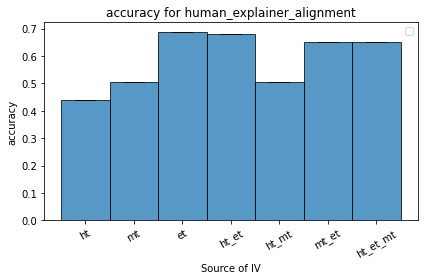

Row index 14
IV: ['human_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.4396
		 'human_t2c' sensitivity: 0.0329
	f1: 0.4374
		 'human_t2c' sensitivity: 0.0277
Row index 15
IV: ['model_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.5057
		 'model_t2c' sensitivity: 0.0617
	f1: 0.5057
		 'model_t2c' sensitivity: 0.0551
Row index 16
IV: ['explainer_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.6881
		 'explainer_t2c' sensitivity: 0.1215
	f1: 0.6461
		 'explainer_t2c' sensitivity: 0.1534
Row index 17
IV: ['human_t2c', 'explainer_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.6784
		 'human_t2c' sensitivity: 0.0087
		 'explainer_t2c' sensitivity: 0.1196
	f1: 0.6388
		 'human_t2c' sensitivity: 0.0107
		 'explainer_t2c' sensitivity: 0.1496
Row index 18
IV: ['human_t2c', 'model_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.5048
		 'human_t2c' sensitivity: 0.0057
		 'model_t2c' sensitivity: 0.0458
	f1: 0.5047
		 'human_

In [26]:
logreg_df_path = os.path.join(cur_group_save_dir, 'logreg_results', 'sensitivity.csv')
# logreg_df_path = 'saved/ADE20K/survey_results/group_1_3/logreg_results/sensitivity.csv'
logreg_df = pd.read_csv(logreg_df_path)
ivs = ['t2c']
dv = 'human_explainer_alignment'
metrics = ['accuracy', 'f1']
drop_correlated = True

cur_logreg_df = filter_df(logreg_df,
    ivs=ivs,
    dv=dv)

# Drop rows that have correlated variables
if drop_correlated:
    drop_idxs = []
    for idx, row in cur_logreg_df.iterrows():
        row_ivs = string_to_list(row['iv'], dtype='string')
        row_ivs = [word.replace("'", "") for word in row_ivs]
        
        # if len(row_ivs) > 2:
        #     drop_idxs.append(row['Unnamed: 0'])
        if len(row_ivs) == 2:
            var1, var2 = row_ivs
            if (var1, var2) in low_corr_set or (var2, var1) in low_corr_set:
                print("({}, {}) has low correlation".format(var1, var2))
            elif (var1, var2) in med_corr_set or (var2, var1) in med_corr_set:
                print("({}, {}) has moderate correlation".format(var1, var2))
            else:
                drop_idxs.append(row['Unnamed: 0'])
                print("Dropping ({}, {})".format(var1, var2))
    cur_logreg_df = cur_logreg_df.drop(drop_idxs, axis=0)

log_path = 'temp/temp.txt'
highest_acc_row = cur_logreg_df.loc[cur_logreg_df['accuracy'].idxmax()]
print("Highest accuracy with {}: {:.4f}".format(
    highest_acc_row['iv'],
    highest_acc_row['accuracy']))

plot_metric_v_inputs(
    df=cur_logreg_df,
    ivs=ivs,
    dv=dv,
    graph_metric='accuracy')
print_summary(
    df=cur_logreg_df,
    metrics=metrics,
    log_path=log_path)

In [37]:
# Start with just groups 2,4,5
cur_df_path = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/group_2_4_5.csv'
cur_df = pd.read_csv(cur_df_path)
cur_group_save_dir = os.path.dirname(cur_df_path)

one_hot_labels = cur_df[['case2', 'case4', 'case5']].to_numpy()
for row in one_hot_labels:
    assert np.sum(row) == 1
labels = np.argmax(one_hot_labels, axis=1)
'''
0 -> 2
1 -> 4
2 -> 5
'''
cur_df['labels'] = labels

unique_labels, unique_counts = np.unique(labels, return_counts=True)
for l, c in zip(unique_labels, unique_counts):
    print("Label {} has {} occurrences".format(l, c))

Label 0 has 166 occurrences
Label 1 has 137 occurrences
Label 2 has 406 occurrences


In [53]:
# Set constants
seed = 1
penalty = 'l2'
solver = 'lbfgs'
class_weight = 'balanced'
multi_class = 'ovr'
logistic_regression_args = {
    'penalty': penalty,
    'solver': solver,
    'class_weight': class_weight,
    'multi_class': multi_class
}

metric_names = ['accuracy', 'precision', 'recall', 'f1'] #, 'neg_log_loss']

# Split dataframe into train/test
train_split = 0.7
train_rows = cur_df.sample(frac=train_split, random_state=seed)
print(train_rows['labels'][:5])
val_rows = cur_df.drop(train_rows.index)
assert len(set(train_rows.index).intersection(set(val_rows.index))) == 0

for split_name, rows in [('train', train_rows), ('test', val_rows)]:
    unique_labels, unique_counts = np.unique(rows['labels'], return_counts=True)
    for l, c in zip(unique_labels, unique_counts):
        print("[{}] Label {} has {} occurrences".format(split_name, l, c))
# Create x, y data
iv_types = ['top_confidence', 'entropy', 't2c']
agents = ['human', 'model', 'explainer']


agents_list = [
    ['human'],
    ['model'],
    ['explainer'],
    ['human', 'explainer'],
    ['human', 'model'],
    ['model', 'explainer'],
    ['human', 'explainer', 'model']
]


189    1
111    0
551    2
429    2
666    2
Name: labels, dtype: int64
[train] Label 0 has 123 occurrences
[train] Label 1 has 91 occurrences
[train] Label 2 has 282 occurrences
[test] Label 0 has 43 occurrences
[test] Label 1 has 46 occurrences
[test] Label 2 has 124 occurrences


In [94]:
def multiclass_run_feature_importance_trial(train_rows,
                                 val_rows,
                                 x_names,
                                 y_names,
                                 metric_names,
                                 trial_id,
                                 logistic_regression_args,
                                 seed):
    # Get metric fns from names
    metric_fns = [getattr(module_metric, metric_name) for metric_name in metric_names]

    # Create structure for storing trial run
    cur_data = {}
    
    # Obtain x, y data
    train_x = train_rows[x_names].to_numpy()
    train_y = np.squeeze(train_rows[y_names].to_numpy())
    assert len(train_x) == len(train_y)
    val_x = val_rows[x_names].to_numpy()
    val_y = np.squeeze(val_rows[y_names].to_numpy())
    assert len(val_x) == len(val_y)

    # add iv, dv to data
    cur_data['iv'] = x_names
    cur_data['dv'] = y_names
    trial_key = "{} {}".format(trial_id, str((x_names, y_names)))

    # Scale the features to be between [0, 1]
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train_x)
    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)

    # Perform hyperparameter search on classifier
    clf = hyperparam_search(
        train_features=train_x,
        train_labels=train_y,
        val_features=val_x,
        val_labels=val_y,
        scaler=None,
        logistic_regression_args=logistic_regression_args)

    print("Learned classifier to predict {} from {}".format(y_names, x_names))
    print("Coefficients: {}".format(clf.coef_))
    # Obtain predictions on validation set
    val_predictions = clf.predict(val_x)
    
    # Print count of unique predictions
    unique, unique_counts = np.unique(val_predictions, return_counts=True)
    print("Predictions:")
    for val, count in zip(unique, unique_counts):
        print("{}: {:.2f}".format(val, 100 * count / len(val_predictions)))
    # Calculate metrics
    metrics = module_metric.compute_metrics(
        metric_fns=metric_fns,
        prediction=val_predictions.ravel(),
        target=val_y.ravel(),
        save_mean=True)
    for metric_name in metric_names:
        if '{}_mean'.format(metric_name) in metrics:
            cur_data[metric_name] = metrics['{}_mean'.format(metric_name)]
            cur_data['{}_per_class'.format(metric_name)] = metrics[metric_name]
        elif metric_name in metrics:
            cur_data[metric_name] = metrics[metric_name]

    # For multi class case, modify metric names to include averaging method
    importance_metric_names = []
    need_average = set(['precision', 'recall', 'f1'])
    for metric in metric_names:
        if metric in need_average:
            importance_metric_names.append('{}_weighted'.format(metric))
        else:
            importance_metric_names.append(metric)
            # Calculate variable sensitivity to each metric
    importance_results = inspection.permutation_importance(
        estimator=clf,
        X=train_x,
        y=train_y.ravel(),
        scoring=importance_metric_names,
        random_state=seed,
        n_repeats=50)
    for metric_name, cur_importance_results in importance_results.items():
        if 'weighted' in metric_name:
            metric_name = metric_name.split('_weighted')[0]
        cur_data['{}_sensitivity_mean'.format(metric_name)] = cur_importance_results['importances_mean'].tolist()
        cur_data['{}_sensitivity_std'.format(metric_name)] = cur_importance_results['importances_std'].tolist()
    
    # Calculate coefficient importance 
    coefficient_t, coefficient_p = get_coefficient_significance(
        X=train_x,
        y=train_y.ravel(),
        classifier=clf)
    cur_data['coefficient_t'] = coefficient_t.tolist()[0]
    cur_data['coefficient_p'] = coefficient_p.tolist()[0]
    
    return {
        'clf': clf,
        'cur_data': cur_data, 
        'trial_key': trial_key
    }


def print_summary(df, 
                  metrics=['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss'],
                  graph_metric=None,
                  print_coefficient_importance=False,
                  log_path=None):
    sensitivity_metrics = ['{}_sensitivity_mean'.format(metric) for metric in metrics]

    for idx, row in df.iterrows():
        informal_log("Row index {}".format(idx), log_path)
        informal_log("IV: {} \nDV: {}".format(row['iv'], row['dv']), log_path)
        informal_log("Metrics", log_path)
        ivs = string_to_list(row['iv'])
        
        # Print metrics and the variable sensitivity
        for metric in metrics:
            
            try: 
                informal_log("\t{}: {:.4f}".format(metric, row[metric]), log_path)
                metric_sensitivities = string_to_list(
                    row['{}_sensitivity_mean'.format(metric)],
                    dtype='float')
                for iv, metric_sensitivity in zip(ivs, metric_sensitivities):
                    informal_log("\t\t {} sensitivity: {:.4f}".format(iv, metric_sensitivity), log_path)
            except:
                informal_log("\t{}: {}".format(metric, row[metric]), log_path)
                continue
        # Print coefficient importance scores and p-values
        if print_coefficient_importance:
            informal_log("Coefficient significance:", log_path)
            coefficient_ts = string_to_list(row['coefficient_t'], dtype='float')
            coefficient_ps = string_to_list(row['coefficient_p'], dtype='float')
            for idx, iv in enumerate(ivs):
                coefficient_t = coefficient_ts[idx]
                coefficient_p = coefficient_ps[idx]

                informal_log("\t{} t: {:.4f} p-value: {:.4f}".format(iv, coefficient_t, coefficient_p), log_path)

In [89]:
# List to store results from all trials
trials = []
clfs = []
trial_keys = []
trial_idx = 1
n_trials = len(iv_types) * len(agents_list) * 1 #len(agent_pairs)
y_names = ['labels']
for iv_type in iv_types:
    for idx, agents in enumerate(agents_list):
        x_names = ['{}_{}'.format(agent, iv_type) for agent in agents]
        for x_name in x_names:
            assert x_name in cur_df.columns 
        
        # for agent1, agent2 in agent_pairs:
        # set seed 
        seed = 0
        # y_names = ['{}_{}_alignment'.format(agent1, agent2)]
        print("Itr {}/{}: IV: {} DV: {}".format(trial_idx, n_trials, x_names, y_names))
        trial_return = multiclass_run_feature_importance_trial(
            train_rows=train_rows,
            val_rows=val_rows,
            x_names=x_names,
            y_names=y_names,
            metric_names=metric_names,
            trial_id=trial_idx-1,
            logistic_regression_args=logistic_regression_args,
            seed=seed)
        
        clf = trial_return['clf']
        cur_data = trial_return['cur_data']
        trial_key = trial_return['trial_key']
        
        clf = hyperparam_search(
            train_features=train_rows[x_names],
            train_labels=train_rows[y_names].values.ravel(),
            val_features=val_rows[x_names],
            val_labels=val_rows[y_names].values.ravel(),
            logistic_regression_args=logistic_regression_args)
        
        val_preds = clf.predict(val_rows[x_names])
        unique_preds, unique_counts = np.unique(val_preds, return_counts=True)
        for p, c in zip(unique_preds, unique_counts):
            print("{} has {} counts".format(p, c))

        clfs.append(clf)
        trials.append(cur_data)
        trial_keys.append(trial_key)
        trial_idx += 1


Itr 1/21: IV: ['human_top_confidence'] DV: ['labels']
Best accuracy: 0.2112676056338028 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_top_confidence']
Coefficients: [[-0.00277204]
 [ 0.00399504]
 [-0.00033056]]
Predictions:
0: 34.27
1: 61.97
2: 3.76
Best accuracy: 0.18779342723004694 Regularization: 0.001
Best accuracy: 0.2112676056338028 Regularization: 0.005
0 has 73 counts
1 has 132 counts
2 has 8 counts
Itr 2/21: IV: ['model_top_confidence'] DV: ['labels']
Best accuracy: 0.38497652582159625 Regularization: 0.001
Learned classifier to predict ['labels'] from ['model_top_confidence']
Coefficients: [[ 0.01048404]
 [ 0.00325236]
 [-0.00995292]]
Predictions:
0: 46.01
1: 4.23
2: 49.77
Best accuracy: 0.38497652582159625 Regularization: 0.001
0 has 98 counts
1 has 9 counts
2 has 106 counts
Itr 3/21: IV: ['explainer_top_confidence'] DV: ['labels']
Best accuracy: 0.5117370892018779 Regularization: 0.001
Best accuracy: 0.5164319248826291 Regularization: 0.5
Best 

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Best accuracy: 0.2676056338028169 Regularization: 0.001
Best accuracy: 0.27230046948356806 Regularization: 0.01
Best accuracy: 0.2863849765258216 Regularization: 0.05
Best accuracy: 0.3286384976525822 Regularization: 0.1
Best accuracy: 0.3615023474178404 Regularization: 0.5
Best accuracy: 0.4084507042253521 Regularization: 1
Best accuracy: 0.4131455399061033 Regularization: 3
1 has 115 counts
2 has 98 counts
Itr 9/21: IV: ['model_entropy'] DV: ['labels']
Best accuracy: 0.4084507042253521 Regularization: 0.001
Learned classifier to predict ['labels'] from ['model_entropy']
Coefficients: [[-0.00921062]
 [-0.00331274]
 [ 0.00902366]]
Predictions:
0: 42.25
1: 3.29
2: 54.46
Best accuracy: 0.4084507042253521 Regularization: 0.001
0 has 90 counts
1 has 7 counts
2 has 116 counts
Itr 10/21: IV: ['explainer_entropy'] DV: ['labels']
Best accuracy: 0.5117370892018779 Regularization: 0.001
Learned classifier to predict ['labels'] from ['explainer_entropy']
Coefficients: [[-0.01103637]
 [-0.0049544 

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Best accuracy: 0.5117370892018779 Regularization: 0.001
0 has 66 counts
1 has 4 counts
2 has 143 counts
Itr 11/21: IV: ['human_entropy', 'explainer_entropy'] DV: ['labels']
Best accuracy: 0.5211267605633803 Regularization: 0.001
Best accuracy: 0.5305164319248826 Regularization: 0.05
Learned classifier to predict ['labels'] from ['human_entropy', 'explainer_entropy']
Coefficients: [[ 0.06912163 -0.44857279]
 [-0.16972706 -0.199964  ]
 [ 0.04943402  0.46907582]]
Predictions:
0: 21.60
1: 14.08
2: 64.32
Best accuracy: 0.5070422535211268 Regularization: 0.001
Best accuracy: 0.5117370892018779 Regularization: 0.01
Best accuracy: 0.5211267605633803 Regularization: 0.05
Best accuracy: 0.5258215962441315 Regularization: 0.5
0 has 45 counts
1 has 32 counts
2 has 136 counts
Itr 12/21: IV: ['human_entropy', 'model_entropy'] DV: ['labels']
Best accuracy: 0.38967136150234744 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_entropy', 'model_entropy']
Coefficients: [[ 0.0014

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Best accuracy: 0.431924882629108 Regularization: 0.001
0 has 83 counts
1 has 2 counts
2 has 128 counts
Itr 17/21: IV: ['explainer_t2c'] DV: ['labels']
Best accuracy: 0.4694835680751174 Regularization: 0.001
Best accuracy: 0.49295774647887325 Regularization: 0.005
Best accuracy: 0.49765258215962443 Regularization: 5
Learned classifier to predict ['labels'] from ['explainer_t2c']
Coefficients: [[-1.60981951]
 [ 0.08643148]
 [ 1.31583047]]
Predictions:
0: 29.58
1: 5.16
2: 65.26
Best accuracy: 0.49295774647887325 Regularization: 0.001
Best accuracy: 0.49765258215962443 Regularization: 1
0 has 63 counts
1 has 11 counts
2 has 139 counts
Itr 18/21: IV: ['human_t2c', 'explainer_t2c'] DV: ['labels']
Best accuracy: 0.352112676056338 Regularization: 0.001
Best accuracy: 0.3568075117370892 Regularization: 0.005
Best accuracy: 0.37089201877934275 Regularization: 0.01
Best accuracy: 0.40375586854460094 Regularization: 0.05
Best accuracy: 0.431924882629108 Regularization: 0.1
Best accuracy: 0.4647887

In [71]:
print(cur_group_save_dir)

saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5


In [90]:
# Create save directory
logreg_save_dir = os.path.join(cur_group_save_dir, 'logreg_results')
ensure_dir(logreg_save_dir)

# Save feature importance results in different forms
logreg_df = pd.DataFrame(trials)
logreg_df_path = os.path.join(logreg_save_dir, 'sensitivity.csv')
logreg_df.to_csv(logreg_df_path)
print("Saved sensitivity results to {}".format(logreg_df_path))

# Write map of trial idx to iv/dv combination
trial_keys_path = os.path.join(logreg_save_dir, 'trial_keys.txt')
write_lists(trial_keys, trial_keys_path)

# Save logistic regression arguments
logreg_args_save_path = os.path.join(logreg_save_dir, 'logreg_args.json')
with open(logreg_args_save_path, 'w') as f:
    json.dump(logistic_regression_args, f)
print("Saved logistic regression arguments to {}".format(logreg_args_save_path))

# Save classifiers
clf_save_path = os.path.join(logreg_save_dir, 'clfs.pth')
torch.save(clfs, clf_save_path)
print("Saved classifiers to {}".format(clf_save_path))

Saved sensitivity results to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/logreg_results/sensitivity.csv
Saved logistic regression arguments to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/logreg_results/logreg_args.json
Saved classifiers to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/logreg_results/clfs.pth


In [40]:
# Obtain correlated pairs 
all_x_names = [
    'human_top_confidence', 'model_top_confidence', 'explainer_top_confidence', 
    'human_entropy', 'model_entropy', 'explainer_entropy', 
    'human_t2c', 'model_t2c', 'explainer_t2c'
]
low_corr_set, med_corr_set, high_corr_set = correlated_variables(
    train_rows=train_rows,
    x_names=all_x_names)

Low correlation pairs (<0.3)
('human_top_confidence', 'model_top_confidence', -0.0961635512137299, 0.032255911859966756)
('human_top_confidence', 'explainer_top_confidence', 0.09492238868733835, 0.03456122749886823)
('human_top_confidence', 'model_entropy', 0.09512252053757662, 0.03418028011140068)
('human_top_confidence', 'explainer_entropy', -0.06216045974841783, 0.1669031808779382)
('human_top_confidence', 'model_t2c', 0.10262776068286714, 0.022260076598722905)
('human_top_confidence', 'explainer_t2c', -0.09084339595941535, 0.04314982863172965)
('model_top_confidence', 'explainer_top_confidence', 0.014182553778192124, 0.7527013889175116)
('model_top_confidence', 'human_entropy', 0.07317104096568249, 0.10359546018990881)
('model_top_confidence', 'explainer_entropy', -0.025069085087258646, 0.5775315979395724)
('model_top_confidence', 'human_t2c', 0.10609704100030681, 0.01809804190264481)
('model_top_confidence', 'explainer_t2c', 0.02183639471236018, 0.6275696453823711)
('explainer_top

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(human_top_confidence, explainer_top_confidence) has low correlation
(human_top_confidence, model_top_confidence) has low correlation
(model_top_confidence, explainer_top_confidence) has low correlation
Highest accuracy with ['explainer_top_confidence']: 0.5258


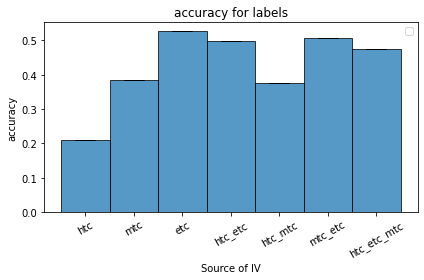

Row index 0
IV: ['human_top_confidence'] 
DV: ['labels']
Metrics
	accuracy: 0.2113
		 'human_top_confidence' sensitivity: 0.0112
	recall: 0.3043
		 'human_top_confidence' sensitivity: 0.0112
	recall_per_class: [0.25581395 0.60869565 0.0483871 ]
	f1: 0.1984
		 'human_top_confidence' sensitivity: 0.0054
	f1_per_class: [0.18965517 0.31460674 0.09090909]
Row index 1
IV: ['model_top_confidence'] 
DV: ['labels']
Metrics
	accuracy: 0.3850
		 'model_top_confidence' sensitivity: 0.0510
	recall: 0.3359
		 'model_top_confidence' sensitivity: 0.0510
	recall_per_class: [0.48837209 0.04347826 0.47580645]
	f1: 0.2945
		 'model_top_confidence' sensitivity: 0.0430
	f1_per_class: [0.29787234 0.07272727 0.51304348]
Row index 2
IV: ['explainer_top_confidence'] 
DV: ['labels']
Metrics
	accuracy: 0.5258
		 'explainer_top_confidence' sensitivity: 0.0780
	recall: 0.4018
		 'explainer_top_confidence' sensitivity: 0.0780
	recall_per_class: [0.44186047 0.02173913 0.74193548]
	f1: 0.3589
		 'explainer_top_confide

In [98]:
logreg_df_path = os.path.join(cur_group_save_dir, 'logreg_results', 'sensitivity.csv')
# logreg_df_path = 'saved/ADE20K/survey_results/group_1_3/logreg_results/sensitivity.csv'
logreg_df = pd.read_csv(logreg_df_path)
ivs = ['top_confidence']
dv = 'labels'
metrics = ['accuracy', 'recall', 'recall_per_class', 'f1', 'f1_per_class']
drop_correlated = True

cur_logreg_df = filter_df(logreg_df,
    ivs=ivs,
    dv=dv)

# Drop rows that have correlated variables
if drop_correlated:
    drop_idxs = []
    for idx, row in cur_logreg_df.iterrows():
        row_ivs = string_to_list(row['iv'], dtype='string')
        row_ivs = [word.replace("'", "") for word in row_ivs]
        
        # if len(row_ivs) > 2:
        #     drop_idxs.append(row['Unnamed: 0'])
        if len(row_ivs) == 2:
            var1, var2 = row_ivs
            if (var1, var2) in low_corr_set or (var2, var1) in low_corr_set:
                print("({}, {}) has low correlation".format(var1, var2))
            elif (var1, var2) in med_corr_set or (var2, var1) in med_corr_set:
                print("({}, {}) has moderate correlation".format(var1, var2))
            else:
                drop_idxs.append(row['Unnamed: 0'])
                print("Dropping ({}, {})".format(var1, var2))
    cur_logreg_df = cur_logreg_df.drop(drop_idxs, axis=0)

log_path = 'temp/temp.txt'
highest_acc_row = cur_logreg_df.loc[cur_logreg_df['accuracy'].idxmax()]
print("Highest accuracy with {}: {:.4f}".format(
    highest_acc_row['iv'],
    highest_acc_row['accuracy']))

plot_metric_v_inputs(
    df=cur_logreg_df,
    ivs=ivs,
    dv=dv,
    graph_metric='accuracy')
print_summary(
    df=cur_logreg_df,
    metrics=metrics,
    log_path=log_path)

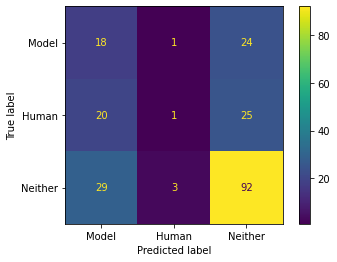

In [105]:
logreg_restore_dir = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/logreg_results'
clfs_path = os.path.join(logreg_restore_dir, 'clfs.pth')
clfs = torch.load(clfs_path)

clf_idx = 2 # 2 is using explainer top confidence
x_names = ['explainer_top_confidence']
clf = clfs[clf_idx]
val_X = val_rows[x_names]
val_y = val_rows[y_names]
unique_labels = [0, 1, 2]
predictions = clf.predict(val_X)

cmat = sklearn.metrics.confusion_matrix(
        val_y,
        predictions,
        labels=unique_labels)

cmat_display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=cmat,
    display_labels=['Model', 'Human', 'Neither'])
cmat_display.plot()
plt.show()

## Visualization of Images in Each Breakdown

#### Display Images from each Breakdown

In [172]:
# Setup
# Load images
if dataset == 'cifar':
    data_path = 'data/cifar10-processed/cifar10_image_labels.pth'
    data = torch.load(data_path)
    test_images = data['test']['images'] / 255.0
    test_labels = data['test']['predictions']
elif dataset == 'ADE20K':
    ade20k_data_path = 'data/broden1_224/images'
    image_paths = df['filename'].values
    test_images = []
    full_image_paths = []
    path_idx_dict = {}
    for idx, image_path in enumerate(image_paths):
        full_image_path = os.path.join(ade20k_data_path, image_path)
        image = load_image(full_image_path)
        test_images.append(image)
        full_image_paths.append(full_image_path)
        path_idx_dict[image_path] = idx
    test_images = np.stack(test_images, axis=0)
    assert len(test_images) == len(image_paths)

group_csvs_dir = os.path.join(os.path.dirname(master_csv_path), 'group_csvs')
group_names = ['group_{}'.format(i) for i in range(1, 6)]

image_save_dir = os.path.join(os.path.dirname(group_csvs_dir), 'visualizations')
ensure_dir(image_save_dir)

dfs = []
idxs = []
n_total = len(df)
for group_name in group_names:
    csv_path = os.path.join(group_csvs_dir, '{}.csv'.format(group_name))
    cur_df = pd.read_csv(csv_path)
    print("{} has {} samples ({:.2f}%)".format(group_name, len(cur_df), len(cur_df) * 100 / n_total))
    dfs.append(cur_df)
    if dataset == 'cifar':
        idxs.append(cur_df['image_idxs'].values)
    elif dataset == 'ADE20K':
        image_paths = cur_df['filename'].values
        cur_idxs = []
        for path in image_paths:
            cur_idxs.append(path_idx_dict[path])
        cur_idxs = np.array(cur_idxs)
        idxs.append(cur_idxs)
    else:
        raise ValueError("Dataset '{}' unsupported. Try {}".format(dataset, datasets_available))


group_1 has 132 samples (44.00%)
group_2 has 58 samples (19.33%)
group_3 has 62 samples (20.67%)
group_4 has 13 samples (4.33%)
group_5 has 35 samples (11.67%)


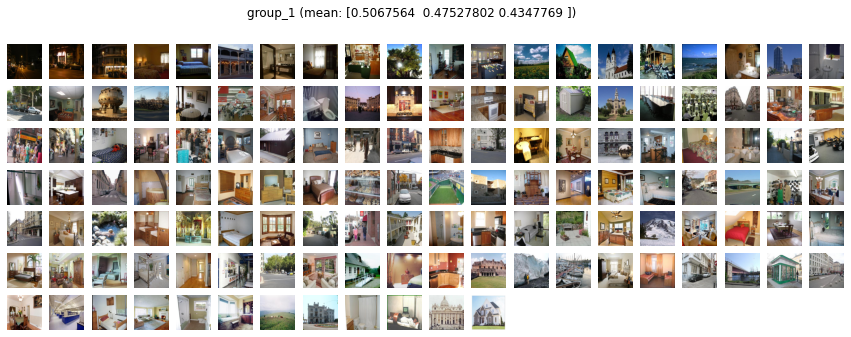

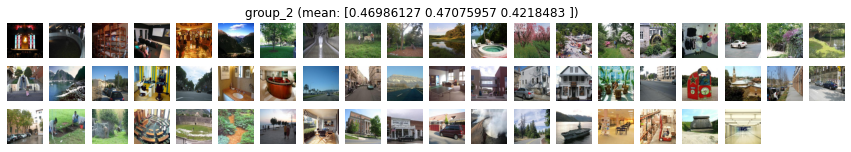

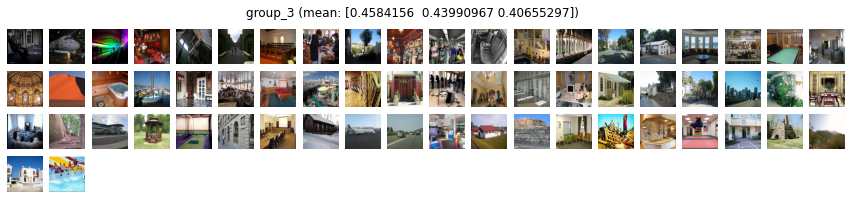

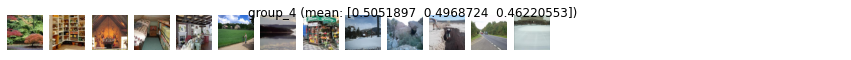

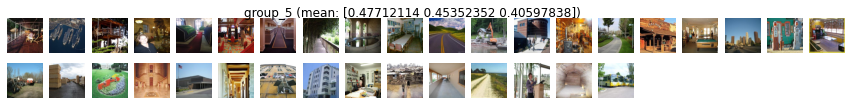

Saved images to saved/ADE20K/survey_results/visualizations


In [170]:
seed = 0
max_images = 200
images_per_row = 20
display_size = (0.75, 0.75)
def display_images(dfs,
                   group_names,
                   idxs,
                   images_array,
                   image_save_dir=None):
    for df, group_name, image_idxs in zip(dfs, group_names, idxs):
        n_samples = min(len(df), max_images)
        # Randomly select max_images rows
        df = df.sample(n=n_samples, random_state=seed)
        # image_idxs = df['image_idxs'].values

        images = images_array[image_idxs, ...]
        # Sort images by increasing average pixel intensity
        mean_pixel_val = np.mean(images, axis=(1, 2, 3))
        mean_per_channel = np.mean(images, axis=(0, 1, 2))
        sort_idxs = np.argsort(mean_pixel_val)
        images = images[sort_idxs, ...]
        images = make_grid(
            flattened=images,
            items_per_row=images_per_row)
        
        if image_save_dir is not None:
            visualization_save_path = os.path.join(image_save_dir, '{}_{}_samples.pdf'.format(group_name, len(image_idxs)))
        else:
            visualization_save_path = None
        show_image_rows(
            images=images,
            figure_title='{} (mean: {})'.format(group_name, mean_per_channel),
            image_size=display_size,
            save_path=visualization_save_path)
        
display_images(
    dfs=dfs,
    group_names=group_names,
    idxs=idxs,
    images_array=test_images,
    image_save_dir=image_save_dir)
print("Saved images to {}".format(image_save_dir))


### Pixel Entropy (probably useless)

#### Calculate mean pixel values and if any differences are statistically significant

In [171]:
import scipy.stats as stats
seed = 0
print_only_significant = True
significance_threshold = 0.05

# Calculate mean pixel values for entirety of groups
for group_name, image_idxs in zip(group_names, idxs):
    images = test_images[image_idxs]
    mean_pixels = np.mean(images, axis=(0, 1, 2))
    std_pixels = np.std(images, axis=(0, 1, 2))
    print("Mean pixel values for {}: {} ({})".format(group_name, mean_pixels, std_pixels))

# Statistical Tests of Significance
print("\nStatistical Significance Tests Across Groups")
if print_only_significant:
    print("Only printing groups with significant differences")
    
for i in range(0, len(idxs) - 1):
    for j in range(i+1, len(idxs)):
        idxs_i = idxs[i]
        idxs_j = idxs[j]
        images_i = test_images[idxs_i]
        images_j = test_images[idxs_j]
        
        mean_pixels_i = np.mean(images_i, axis=(1, 2)) # N x 3
        mean_pixels_j = np.mean(images_j, axis=(1, 2)) 
        
        ttest = stats.ttest_ind(
            a=mean_pixels_i,
            b=mean_pixels_j,
            axis=0,
            equal_var=True,
            random_state=seed)
        print("Groups {} and {}:".format(i+1, j+1))
        for stat, pval, color in zip(ttest.statistic, ttest.pvalue, ["Red", "Green", "Blue"]):
            if not print_only_significant or pval < significance_threshold:
                print("\t{}: {:.4f} (p={:.4f})".format(color, stat, pval))
        

Mean pixel values for group_1: [0.5067564  0.47527802 0.4347769 ] ([0.25108463 0.24980852 0.2658614 ])
Mean pixel values for group_2: [0.46986127 0.47075957 0.4218483 ] ([0.2635727  0.26176694 0.27816844])
Mean pixel values for group_3: [0.4584156  0.43990967 0.40655297] ([0.26365453 0.26298666 0.27988207])
Mean pixel values for group_4: [0.5051897  0.4968724  0.46220553] ([0.24306355 0.24762668 0.27605832])
Mean pixel values for group_5: [0.47712114 0.45352352 0.40597838] ([0.25893688 0.25641719 0.27342176])

Statistical Significance Tests Across Groups
Only printing groups with significant differences
Groups 1 and 2:
	Red: 1.9744 (p=0.0498)
Groups 1 and 3:
	Red: 2.6515 (p=0.0087)
	Green: 2.1434 (p=0.0333)
Groups 1 and 4:
Groups 1 and 5:
Groups 2 and 3:
Groups 2 and 4:
Groups 2 and 5:
Groups 3 and 4:
Groups 3 and 5:
Groups 4 and 5:


In [173]:
# Calculate mean pixel intensity of each group
seed = 0
print_only_significant = True
significance_threshold = 0.05
mean_intensity = []
# Calculate mean intensity for entirety of groups
for group_name, image_idxs in zip(group_names, idxs):
    images = test_images[image_idxs]
    group_mean_intensity = np.mean(images, axis=(1, 2, 3))
    mean_intensity.append(group_mean_intensity)
    print("Mean pixel values for {}: {:.3f} ({:.3f})".format(group_name, np.mean(group_mean_intensity), np.std(group_mean_intensity)))

# Statistical Tests of Significance
print("\nStatistical Significance Tests Across Groups")
if print_only_significant:
    print("Only printing groups with significant differences")
    
for i in range(0, len(mean_intensity) - 1):
    for j in range(i+1, len(mean_intensity)):
        mean_intensity_i = mean_intensity[i]
        mean_intensity_j = mean_intensity[j]
        
        ttest = stats.ttest_ind(
            a=mean_intensity_i,
            b=mean_intensity_j,
            equal_var=True,
            random_state=seed)
        print("Groups {} and {}:".format(i+1, j+1))
        if not print_only_significant or ttest.pvalue < significance_threshold:
            print(" {:.4f} (p={:.4f})".format(ttest.statistic, ttest.pvalue))
        else:
            print("")
        

Mean pixel values for group_1: 0.471 (0.100)
Mean pixel values for group_2: 0.454 (0.102)
Mean pixel values for group_3: 0.435 (0.106)
Mean pixel values for group_4: 0.488 (0.091)
Mean pixel values for group_5: 0.445 (0.114)

Statistical Significance Tests Across Groups
Only printing groups with significant differences
Groups 1 and 2:

Groups 1 and 3:
 2.3273 (p=0.0210)
Groups 1 and 4:

Groups 1 and 5:

Groups 2 and 3:

Groups 2 and 4:

Groups 2 and 5:

Groups 3 and 4:

Groups 3 and 5:

Groups 4 and 5:



#### Calculate entropy of images and average across groups
1. Shannon entropy of RGB channels then average them
2. Shannon entropy of pixel intensities

In [174]:
from skimage.measure import shannon_entropy

##### RGB Entropy

In [175]:
# Calculate Shannon entropy of each RGB channel separately
shannon_rgb_entropies = []
colors = ["Red", "Green", "Blue"]
color_channel = 3

for group_name, image_idxs in zip(group_names, idxs):
    images = test_images[image_idxs]
    assert images.shape[color_channel] == 3, "Color channel {} has {} dimensions. Expected 3.".format(color_channel, images.shape[color_channel])
    entropies = []
    for color_idx, color_name in enumerate(colors):
        if color_channel == 3:
            images_channel = images[:, :, :, color_idx]
        else:
            raise ValueError("Color channel {} not supported".format(color_channel))
        entropies_channel = []
        for image_channel in images_channel:
            entropies_channel.append(shannon_entropy(image_channel))
        entropies.append(entropies_channel)
    entropies = np.array(entropies)
    entropies = np.transpose(entropies, axes=(1, 0))
    
    shannon_rgb_entropies.append(np.array(entropies))
    print("Entropies for {} (Mean, STD)".format(group_name))
    print("Mean:")
    for color, entropy in zip(colors, entropies):
        mean_entropy = np.mean(entropy)
        print("{:.3f}, ".format(mean_entropy), end="")
    print("")
    for color, entropy in zip(colors, entropies):
        std_entropy = np.std(entropy)
        print("{:.3f}, ".format(std_entropy), end="")
    print("")
            

        
        

Entropies for group_1 (Mean, STD)
Mean:
7.612, 7.508, 7.746, 
0.017, 0.012, 0.087, 
Entropies for group_2 (Mean, STD)
Mean:
7.089, 5.963, 7.522, 
0.009, 0.360, 0.046, 
Entropies for group_3 (Mean, STD)
Mean:
7.687, 7.237, 7.850, 
0.036, 0.011, 0.055, 
Entropies for group_4 (Mean, STD)
Mean:
7.804, 7.581, 7.377, 
0.028, 0.024, 0.092, 
Entropies for group_5 (Mean, STD)
Mean:
7.692, 7.397, 7.453, 
0.014, 0.088, 0.129, 


In [177]:
# Calculate statistical significance of RGB entropies across groups
seed = 0
print_only_significant = True
significance_threshold = 0.05

for i in range(0, len(shannon_rgb_entropies) - 1):
    for j in range(i+1, len(shannon_rgb_entropies)):
        entropies_i = shannon_rgb_entropies[i]
        entropies_j = shannon_rgb_entropies[j]
        ttest = stats.ttest_ind(
            a=entropies_i,
            b=entropies_j,
            axis=0,
            equal_var=True,
            random_state=seed)
        print("Groups {} and {}:".format(i+1, j+1))
        for stat, pval, color in zip(ttest.statistic, ttest.pvalue, ["Red", "Green", "Blue"]):
            if not print_only_significant or pval < significance_threshold:
                print("\t{}: {:.4f} (p={:.4f})".format(color, stat, pval))

Groups 1 and 2:
Groups 1 and 3:
Groups 1 and 4:
Groups 1 and 5:
Groups 2 and 3:
Groups 2 and 4:
Groups 2 and 5:
Groups 3 and 4:
Groups 3 and 5:
Groups 4 and 5:


##### Pixel Intensity Entropy

In [179]:
# Calculate Shannon entropy of pixel intensities
shannon_entropies = []
color_channel = 3
print_only_significant = True
significance_threshold = 0.05

for group_name, image_idxs in zip(group_names, idxs):
    images = test_images[image_idxs]
    entropies = []
    grayscale_images = np.mean(images, axis=color_channel)
    
    for grayscale_image in grayscale_images:
        entropies.append(shannon_entropy(grayscale_image))
    
    shannon_entropies.append(np.array(entropies))
    print("Mean entropy for group {}: {:.3f} ({:.3f})".format(group_name, np.mean(entropies), np.std(entropies)))
    
            
# Calculate statistical significance tests
print("Statistical Significance Tests")
for i in range(0, len(shannon_entropies) - 1):
    for j in range(i+1, len(shannon_entropies)):
        entropies_i = shannon_entropies[i]
        entropies_j = shannon_entropies[j]
        ttest = stats.ttest_ind(
            a=entropies_i,
            b=entropies_j,
            equal_var=True,
            random_state=seed)
        print("Groups {} and {}:".format(i+1, j+1), end="")
        if not print_only_significant or ttest.pvalue < significance_threshold:
            print(" {:.4f} (p={:.4f})".format(ttest.statistic, ttest.pvalue))
        else:
            print("")
       

Mean entropy for group group_1: 9.162 (0.411)
Mean entropy for group group_2: 9.118 (0.437)
Mean entropy for group group_3: 9.147 (0.473)
Mean entropy for group group_4: 8.985 (0.577)
Mean entropy for group group_5: 9.158 (0.328)
Statistical Significance Tests
Groups 1 and 2:
Groups 1 and 3:
Groups 1 and 4:
Groups 1 and 5:
Groups 2 and 3:
Groups 2 and 4:
Groups 2 and 5:
Groups 3 and 4:
Groups 3 and 5:
Groups 4 and 5:


### Inspect the explainer's second predictions in cases of misalignment
1. If model != human and explainer = model (group 2), what % of samples if the explainer's second choice = human prediction?
2. If model = human but explainer = neither (group 3), what is the distribution of rank of model/human's top predictions?
3. If model != human and explainer = human (group 4), what % of samples is the explainer's second choice = model prediction?
4. If model != human and explainer = neither (group 5), what is the distribution of rank of model's top prediction? Of human's top prediction?


#### Function Definitions

In [180]:
def get_prediction_rank(probabilities, predictions):
    '''
    Given predictions and probabilities for N samples, return the rank (0-indexed) of the predictions
    
    Arg(s):
        probabilities : N x C np.array
        predictions : N np.array
    Returns:
        N np.array
    '''
    # Get indices to sort probabilities in decreasing order
    sort_idxs = np.argsort(-probabilities)  # N x C array
    n_classes = sort_idxs.shape[1]
    # Expand predictions to match sort_idxs shape
    repeated_predictions = [predictions for i in range(n_classes)]
    repeated_predictions = np.stack(repeated_predictions, axis=1)
    
    # One hot encode the index where the class corresponds to the prediction
    rank_one_hot = np.where(sort_idxs == repeated_predictions, 1, 0)
    # Rank is 0 for higher probability
    rank = np.argsort(rank_one_hot, axis=1)[:, -1]
    return rank

#### Experimental Code

In [181]:
# Collect the logits for each agent and each group
human_probabilities = [] # hold array of logits for each group
model_probabilities = []
explainer_probabilities = []

agents = ['human', 'model', 'explainer']
for df in dfs:
    # Convert string arrays to numpy arrays
    df = convert_string_columns(
        df=df,
        columns=['{}_probabilities'.format(agent) for agent in agents])
    
    cur_human_probabilities = np.stack(df['human_probabilities'].to_numpy(), axis=0)
    assert len(cur_human_probabilities.shape) == 2
    human_probabilities.append(cur_human_probabilities)
    
    cur_model_probabilities = np.stack(df['model_probabilities'].to_numpy(), axis=0)
    assert len(cur_model_probabilities.shape) == 2
    model_probabilities.append(cur_model_probabilities)
    
    cur_explainer_probabilities = np.stack(df['explainer_probabilities'].to_numpy(), axis=0)
    assert len(cur_explainer_probabilities.shape) == 2
    explainer_probabilities.append(cur_explainer_probabilities)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Proportion of samples where human prediction is explainer's second most likely: 0.3793
Mean rank of human predictions: 2.345 (1.718)
Proportion of human predictions are explainer's second prediction: 0.3793


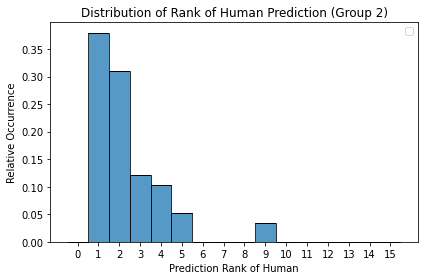

<Axes: title={'center': 'Distribution of Rank of Human Prediction (Group 2)'}, xlabel='Prediction Rank of Human', ylabel='Relative Occurrence'>

In [190]:
# 1. If model != human and explainer = model (group 2), what % of samples if the explainer's second choice = human prediction?
cur_idx = 1 # group 2
cur_human_probabilities = human_probabilities[cur_idx]
cur_model_probabilities = model_probabilities[cur_idx]
cur_explainer_probabilities = explainer_probabilities[cur_idx]

# Assert group 2 invariances
assert (np.argmax(cur_model_probabilities, axis=1) == np.argmax(cur_explainer_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_model_probabilities, axis=1)).all()

cur_human_predictions = np.argmax(cur_human_probabilities, axis=1)
sort_idxs = np.argsort(cur_explainer_probabilities, axis=1)
explainer_second_predictions = sort_idxs[:, -2]
assert explainer_second_predictions.shape == cur_human_predictions.shape

overlap = np.count_nonzero(explainer_second_predictions == cur_human_predictions) / len(cur_human_predictions)
print("Proportion of samples where human prediction is explainer's second most likely: {:.4f}".format(overlap))

human_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_human_predictions)
print("Mean rank of human predictions: {:.3f} ({:.3f})".format(np.mean(human_prediction_rank), np.std(human_prediction_rank)))
print("Proportion of human predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(human_prediction_rank == 1) / len(human_prediction_rank)))

# Create a bar graph
bincount = list(np.bincount(human_prediction_rank) / len(human_prediction_rank))
# Pad bincount
while len(bincount) < n_classes:
    bincount.append(0)
bincount = np.array(bincount)

    
bin_labels = [i for i in range(n_classes)]
bar_graph(
    data=[bincount],
    labels=bin_labels,
    xlabel='Prediction Rank of Human',
    ylabel='Relative Occurrence',
    title='Distribution of Rank of Human Prediction (Group 2)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean rank of human/model predictions: 2.048 (1.835) 
Proportion of human/model predictions are explainer's second prediction: 0.4839


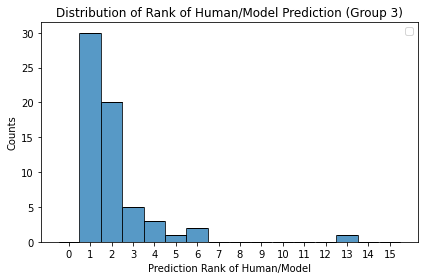

<Axes: title={'center': 'Distribution of Rank of Human/Model Prediction (Group 3)'}, xlabel='Prediction Rank of Human/Model', ylabel='Counts'>

In [192]:
# 2. If model = human but explainer = neither (group 3), what is the distribution of rank of model/human's top predictions?
cur_idx = 2 # group 3
cur_human_probabilities = human_probabilities[cur_idx]
cur_model_probabilities = model_probabilities[cur_idx]
cur_explainer_probabilities = explainer_probabilities[cur_idx]

# Assert group 3 invariances
assert (np.argmax(cur_model_probabilities, axis=1) == np.argmax(cur_human_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_explainer_probabilities, axis=1)).all()
assert (np.argmax(cur_model_probabilities, axis=1) != np.argmax(cur_explainer_probabilities, axis=1)).all()

cur_human_predictions = np.argmax(cur_human_probabilities, axis=1)

human_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_human_predictions)
print("Mean rank of human/model predictions: {:.3f} ({:.3f}) ".format(np.mean(human_prediction_rank), np.std(human_prediction_rank)))
print("Proportion of human/model predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(human_prediction_rank == 1) / len(human_prediction_rank)))

# Create a bar graph
bincount = list(np.bincount(human_prediction_rank))
# Pad bincount
while len(bincount) < n_classes:
    bincount.append(0)
bincount = np.array(bincount)

bin_labels = [i for i in range(n_classes)]
bar_graph(
    data=[bincount],
    labels=bin_labels,
    xlabel='Prediction Rank of Human/Model',
    ylabel='Counts',
    title='Distribution of Rank of Human/Model Prediction (Group 3)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Proportion of samples where model prediction is explainer's second most likely: 0.5385
Mean rank of model predictions: 2.231 (1.928)
Proportion of model predictions are explainer's second prediction: 0.5385


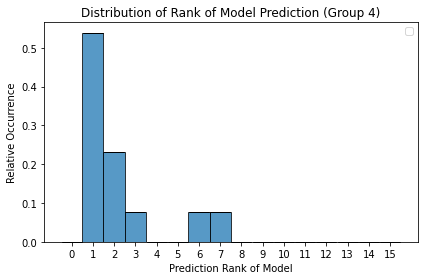

<Axes: title={'center': 'Distribution of Rank of Model Prediction (Group 4)'}, xlabel='Prediction Rank of Model', ylabel='Relative Occurrence'>

In [193]:
# 3. If model != human and explainer = human (group 4), what % of samples is the explainer's second choice = model prediction?
cur_idx = 3 # group 4
cur_human_probabilities = human_probabilities[cur_idx]
cur_model_probabilities = model_probabilities[cur_idx]
cur_explainer_probabilities = explainer_probabilities[cur_idx]

# Assert group 4 invariances
assert (np.argmax(cur_human_probabilities, axis=1) == np.argmax(cur_explainer_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_model_probabilities, axis=1)).all()

cur_model_predictions = np.argmax(cur_model_probabilities, axis=1)
sort_idxs = np.argsort(cur_explainer_probabilities, axis=1)
explainer_second_predictions = sort_idxs[:, -2]
assert explainer_second_predictions.shape == cur_model_predictions.shape

overlap = np.count_nonzero(explainer_second_predictions == cur_model_predictions) / len(cur_model_predictions)
print("Proportion of samples where model prediction is explainer's second most likely: {:.4f}".format(overlap))

model_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_model_predictions)
print("Mean rank of model predictions: {:.3f} ({:.3f})".format(np.mean(model_prediction_rank), np.std(model_prediction_rank)))
print("Proportion of model predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(model_prediction_rank == 1) / len(model_prediction_rank)))

# Create a bar graph
bincount = list(np.bincount(model_prediction_rank) / len(model_prediction_rank))
# Pad bincount
while len(bincount) < n_classes:
    bincount.append(0)
bincount = np.array(bincount)

bin_labels = [i for i in range(n_classes)]
bar_graph(
    data=[bincount],
    labels=bin_labels,
    xlabel='Prediction Rank of Model',
    ylabel='Relative Occurrence',
    title='Distribution of Rank of Model Prediction (Group 4)')

Mean rank of human predictions: 3.486 (2.634)
Proportion of human predictions are explainer's second prediction: 0.2857
Mean rank of model predictions: 3.314 (2.723)
Proportion of model predictions are explainer's second prediction: 0.2571


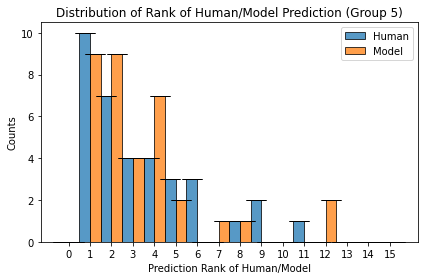

<Axes: title={'center': 'Distribution of Rank of Human/Model Prediction (Group 5)'}, xlabel='Prediction Rank of Human/Model', ylabel='Counts'>

In [194]:
#4. If model != human and explainer = neither (group 5), what is the distribution of rank of model's top prediction? Of human's top prediction?
cur_idx = 4 # group 5
cur_human_probabilities = human_probabilities[cur_idx]
cur_model_probabilities = model_probabilities[cur_idx]
cur_explainer_probabilities = explainer_probabilities[cur_idx]

# Assert group 5 invariances
assert (np.argmax(cur_model_probabilities, axis=1) != np.argmax(cur_explainer_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_model_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_explainer_probabilities, axis=1)).all()

cur_human_predictions = np.argmax(cur_human_probabilities, axis=1)
cur_model_predictions = np.argmax(cur_model_probabilities, axis=1)

human_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_human_predictions)
print("Mean rank of human predictions: {:.3f} ({:.3f})".format(np.mean(human_prediction_rank), np.std(human_prediction_rank)))
print("Proportion of human predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(human_prediction_rank == 1) / len(human_prediction_rank)))

model_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_model_predictions)
print("Mean rank of model predictions: {:.3f} ({:.3f})".format(np.mean(model_prediction_rank), np.std(model_prediction_rank)))
print("Proportion of model predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(model_prediction_rank == 1) / len(model_prediction_rank)))      

# Create a bar graph
human_bincount = list(np.bincount(human_prediction_rank))
model_bincount = list(np.bincount(model_prediction_rank))

# Pad bincounts
while len(human_bincount) < n_classes:
    human_bincount.append(0)
human_bincount = np.array(human_bincount)
while len(model_bincount) < n_classes:
    model_bincount.append(0)
model_bincount = np.array(model_bincount)

bin_labels = [i for i in range(n_classes)]
bar_graph(
    data=[human_bincount, model_bincount],
    groups=['Human', 'Model'],
    labels=bin_labels,
    xlabel='Prediction Rank of Human/Model',
    ylabel='Counts',
    title='Distribution of Rank of Human/Model Prediction (Group 5)')

#### Get class distributions for ground truth, human, model, and explainer

In [ ]:
if dataset == 'cifar':
    
    class_list_path = 'data/cifar10-processed/classes.txt'
    class_list = read_lists(class_list_path)
elif dataset == 'ade20k':
    pass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


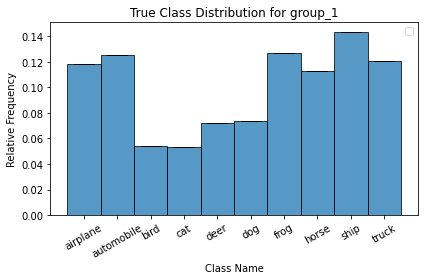

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


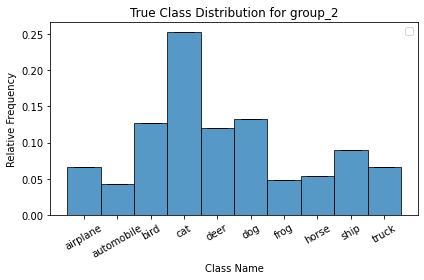

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


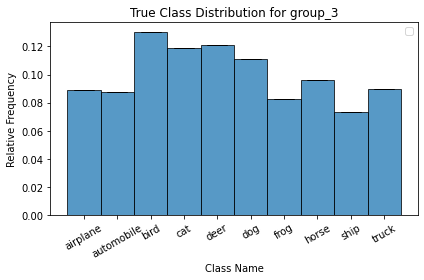

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


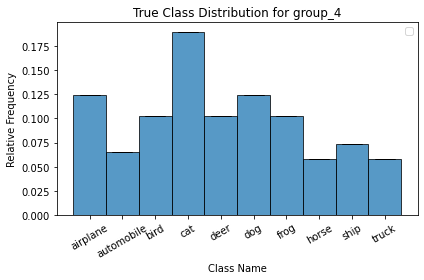

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


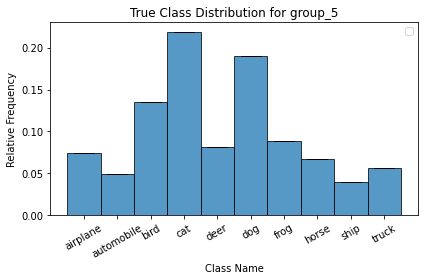

In [21]:
# What is the class distribution for each group?
save_path_template = os.path.join(image_save_dir, 'true_class_dist', '{}_true_class_distribution.png')
ensure_dir(os.path.dirname(save_path_template))

for image_idxs, group_name in zip(idxs, group_names):
    ground_truth_labels = test_labels[image_idxs]
    # print(ground_truth_labels.shape)
    unique, count = np.unique(ground_truth_labels, return_counts=True)
    assert len(unique) == n_classes, "Mismatch number of classes. Expected {} but received {}.".format(n_classes, len(unique))
    count = count / np.sum(count)
    save_path = save_path_template.format(group_name)
    bar_graph(
        data=[count],
        labels=class_list,
        xlabel='Class Name',
        ylabel='Relative Frequency',
        xlabel_rotation=30,
        title='True Class Distribution for {}'.format(group_name),
        save_path=save_path)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


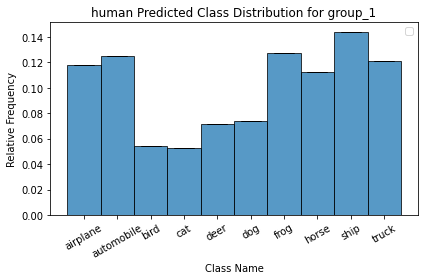

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


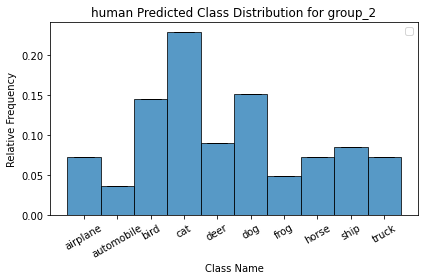

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


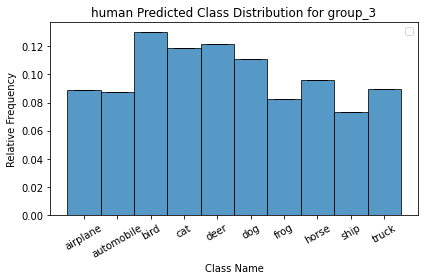

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


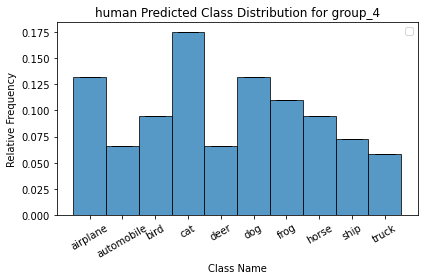

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


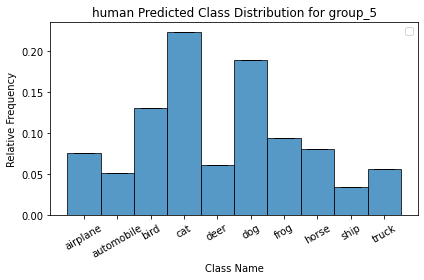

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


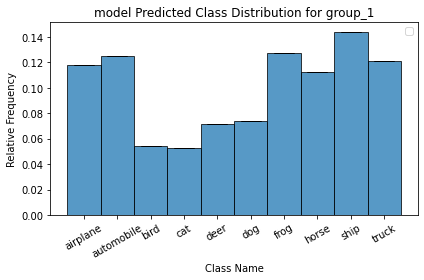

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


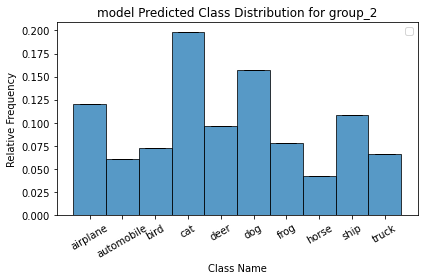

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


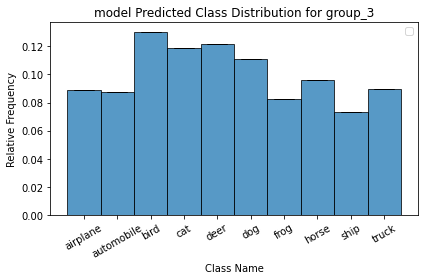

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


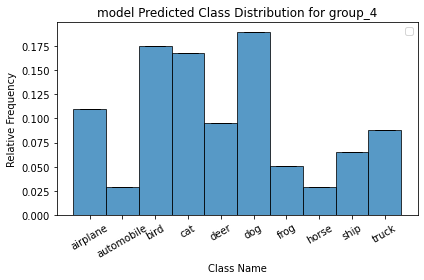

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


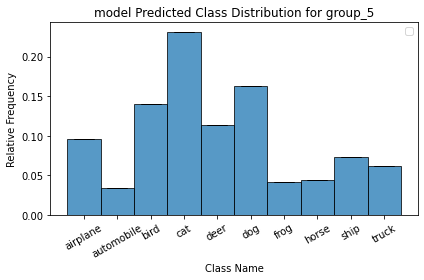

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


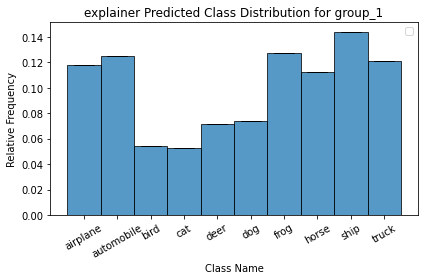

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


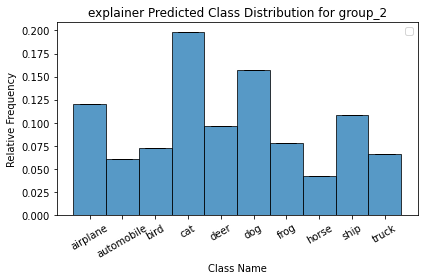

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


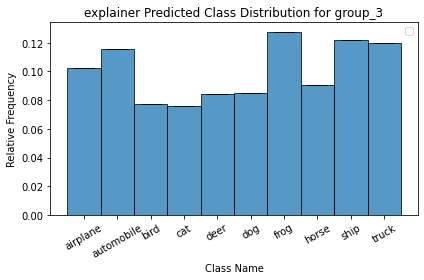

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


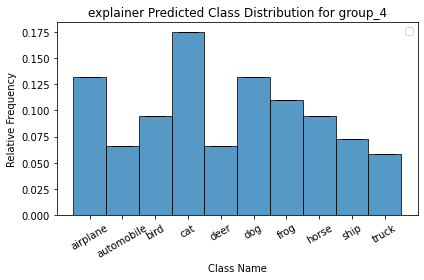

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


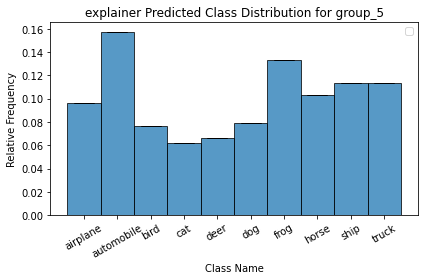

In [27]:
agents = ['human', 'model', 'explainer']

for agent in agents:
    cur_save_dir = os.path.join(image_save_dir, '{}_class_dist'.format(agent))
    ensure_dir(cur_save_dir)
    
    for df, group_name in zip(dfs, group_names):
        predictions = df['{}_predictions'.format(agent)].values
        # print(predictions.shape)
        unique, count = np.unique(predictions, return_counts=True)
        assert len(unique) == n_classes, "Mismatch number of classes. Expected {} but received {}.".format(n_classes, len(unique))
        count = count / np.sum(count)
        save_path = os.path.join(cur_save_dir, '{}_{}_dist.png'.format(group_name, agent))
                   
        bar_graph(
            data=[count],
            labels=class_list,
            xlabel='Class Name',
            ylabel='Relative Frequency',
            xlabel_rotation=30,
            title='{} Predicted Class Distribution for {}'.format(agent, group_name),
            save_path=save_path)